In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch

from noise import biased_randint, add_gaussian_noise


# Generate noise

In [2]:
from noise import load_image, draw_noise_evolution

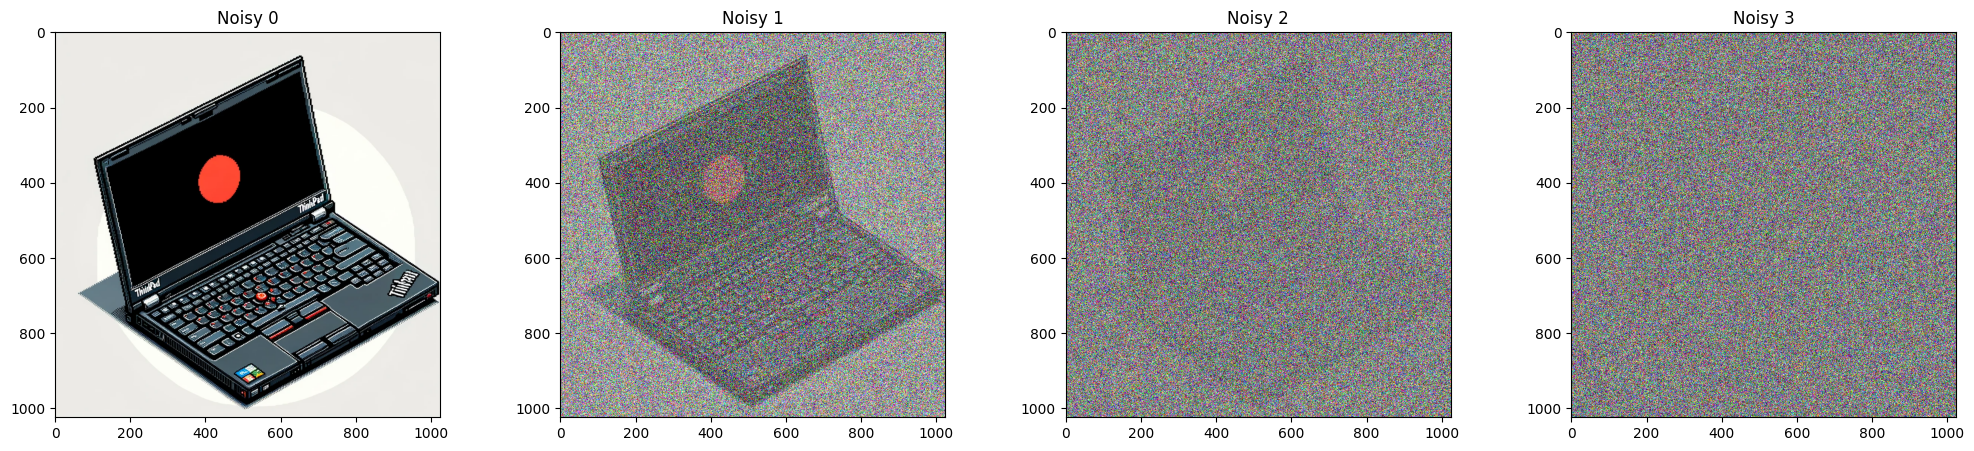

In [3]:
image = load_image("images/ThinkPad_1024.png")

draw_noise_evolution(image, 4, 1.8, "images/noise.png")


# NOTATKI
Batch ma długość 'k', losujemy k oryginalnych obrazków z datasetu</br>
Następnie losujemy dla każdego obrazka krok czasowy/poziom zaszumienia</br>
i każdy oryginalny obrazek zaszumiamy odpowiadającym krokiem</br>

Rozmiar batcha = k, choć można dodać parametry (trzeba dodać krok)

# 3 klasy
klasę typu U-Net
klasa od procesu dyfuzyjnego: dodawanie szumu do obrazka
klasa sampler/solver: odszumia (model, zdjęcie zaszumione)


Model dostaje szum(obrazek), zwraca "szum", który musimy odjąć od szumu(obrazka) na wejściu

Czyli model dostaje obrazek, zwraca średnią rozkładu dla każdego piksela


Samplowanie generuje totalnie losowy szum i odejmuje przewidziany



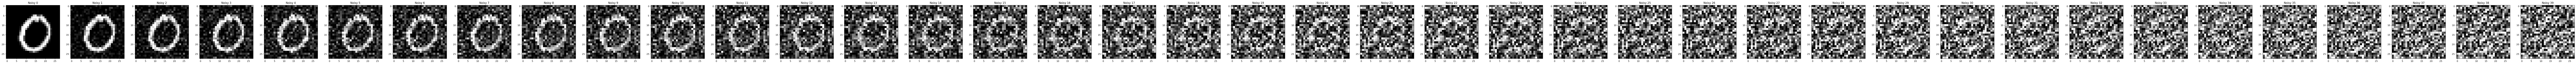

In [4]:
# n = 4
# noise = 0.5
# for i in range(0, 10, 2):
#     image = load_image(f"data/{i}/{i+1}.png")

#     draw_noise_evolution(image, n, noise)


n = 40
noise = 0.12
for i in range(0, 10, 2):
    image = load_image(f"data/{i}/{i+1}.png")

    draw_noise_evolution(image, n, noise)
    break


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"  # TMP
print("Device:", device)


Device: cuda


# Preparing dataset

In [6]:
import matplotlib.pyplot as plt


def plot_images(dataloader, num_images=4):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 3))
    for i_batch, sample_batched in enumerate(dataloader):
        _, noised_images, _ = sample_batched
        
        for i in range(num_images):
            ax[i].imshow(noised_images[i].permute(1, 2, 0).numpy())
            ax[i].axis('off')
        
        break


In [7]:
class NoisedDataset(Dataset):
    def __init__(self, dataset, max_n: int = 4, noise: float = 0.5) -> None:
        print("Noise:", type(noise))
        assert noise > 0
        self.dataset = dataset
        self.max_n = max_n
        self.noise = noise
        self.classes = dataset.classes

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple:
        image, _ = self.dataset[idx]

        nosie_image = image
        current_n = biased_randint(1, self.max_n, 4)

        for _ in range(current_n):
            nosie_image = add_gaussian_noise(nosie_image, std=self.noise)
        # noised_images = torch.stack(noised_images)

        return image, nosie_image, current_n


In [8]:
IMG_SIZE = 64  # nie ma potrzeby powiększania

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="data/1/", transform=transforms.ToTensor())
print("Noise:", type(noise))
dataset = NoisedDataset(dataset, n, noise)

dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

print("Classes:", len(dataset.classes))
print("Records:", len(dataset))


Noise: <class 'float'>
Noise: <class 'float'>
Classes: 1
Records: 10


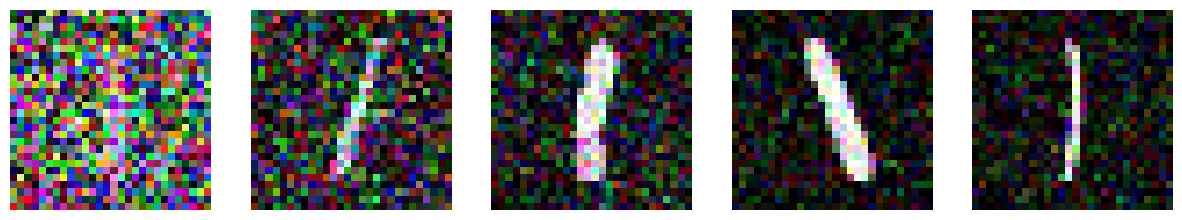

In [9]:
plot_images(dataloader, 5)


In [10]:
for images, noised_images, noises in dataloader:
    print(len(images))  # 5 - batch size
    print(len(images[0]))  # 3 - channels of image
    print(len(noises))  # 5 - noise levels
    break


10
3
10


In [11]:
class ImageModel(nn.Module):
    def __init__(self, input_channels: int = 3, output_channels: int = 3, image_size: tuple[int, int] = (28, 28)) -> None:
        super(ImageModel, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.image_size = image_size

        # Rozszerzony model zawiera więcej warstw i kanałów
        self.conv1 = nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # Dodatkowa warstwa
        
        # Warstwy transponowane konwolucyjne, odpowiadające rozszerzeniu
        self.t_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.t_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=self.output_channels, kernel_size=3, stride=1, padding=1)  # Dodatkowa warstwa

    def forward(self, x):
        # Przechodzimy przez warstwy konwolucyjne
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))  # Przejście przez dodatkową warstwę
        
        # Przechodzimy przez warstwy transponowane konwolucyjne
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = torch.sigmoid(self.t_conv4(x))  # Używamy sigmoid, aby wyjście było między 0 a 1

        return x


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


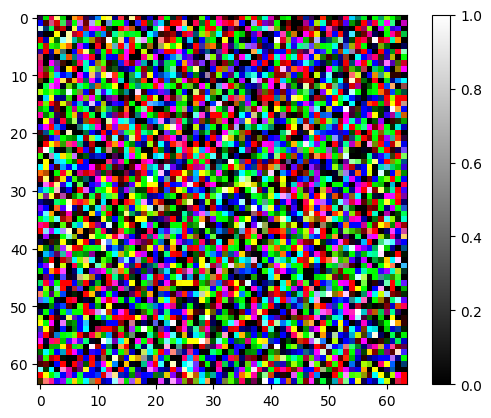

In [12]:

noise_ = torch.normal(mean=0.1, std=1.0, size=(1, 3, IMG_SIZE, IMG_SIZE)).squeeze(0)
noise_ = np.transpose(noise_, (1, 2, 0))

plt.imshow(noise_, cmap="gray")
plt.colorbar()
plt.show()


In [13]:
def generate_image(model, height=28, width=28, n_iterations=40):
    noise = torch.normal(
        mean=0.1,
        std=1.0,
        size=(1, 3, height, width)
        ).to(device)

    with torch.no_grad():
        for _ in range(n_iterations):
            noise = model(noise)

    # Normalize the generated image to [0, 1] for display purposes
    generated_image = (noise - noise.min()) / (noise.max() - noise.min())
    generated_image = generated_image.squeeze(0)  # Remove the batch dimension for display

    return generated_image.cpu().numpy()


def display_generated_images(model, images_to_generate=5, height=28, width=28):
    model.eval()
    plt.figure(figsize=(10, 2))
    for i in range(images_to_generate):
        generated_image = generate_image(model, height=height, width=width)
        plt.subplot(1, images_to_generate, i+1)
        
        # Obrazy są w formacie [channels, height, width], więc trzeba je przekształcić do [height, width, channels]
        plt.imshow(np.transpose(generated_image, (1, 2, 0)))
        plt.axis("off")
    plt.show()
    model.train()


In [14]:
lr = 0.00001

model = ImageModel(image_size=(IMG_SIZE, IMG_SIZE))
# model = torch.load("50epochs.pth")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


In [15]:
def display_generated_images_at_intervals(model, height=28, width=28, n_iterations=40, interval=10):
    """
    Display generated images at specified intervals.

    Parameters:
    - model: The neural network model used for generating images.
    - height: The height of the generated images.
    - width: The width of the generated images.
    - n_iterations: Total number of iterations to run the generation process.
    - interval: The interval at which to capture and display the generated images.
    """
    model.eval()
    
    # Initialize a noise tensor with shape (batch_size=1, channels=3, height, width)
    noise = torch.normal(mean=0.1, std=1.0, size=(1, 3, height, width)).to(device)

    images = []

    with torch.no_grad():
        for iteration in range(1, n_iterations + 1):
            noise = model(noise)
            
            if iteration % interval == 0 or iteration == 1:
                # Normalize the image for display
                img = (noise - noise.min()) / (noise.max() - noise.min())
                images.append(img.squeeze(0).cpu().numpy())  # Remove batch dimension and convert to CPU numpy array

    plt.figure(figsize=(20, 4))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        # Convert image to displayable format
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(f"Iteration: {i * interval if i > 0 else 1}")
        plt.axis("off")
    plt.show()

    model.train()


Epoch 100, Loss: 0.22051969170570374


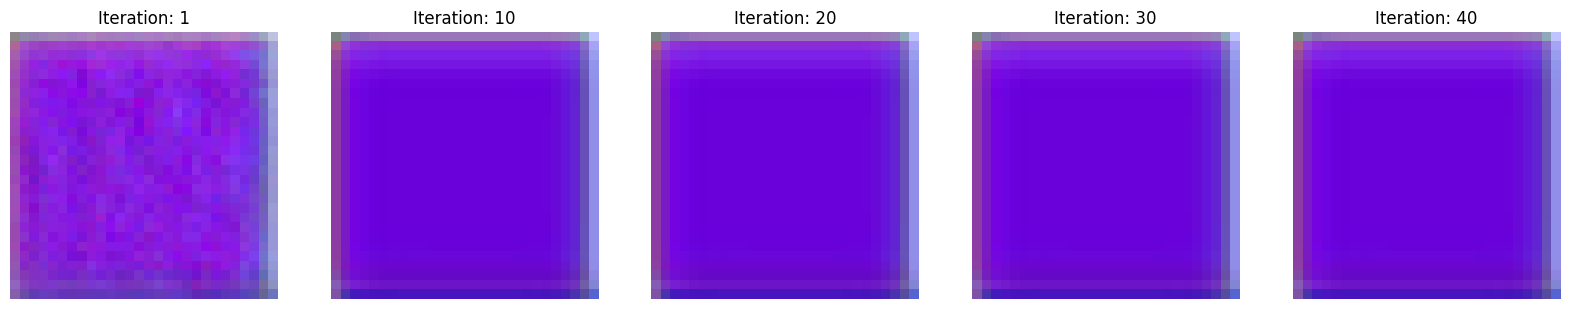

Epoch 200, Loss: 0.11670256406068802


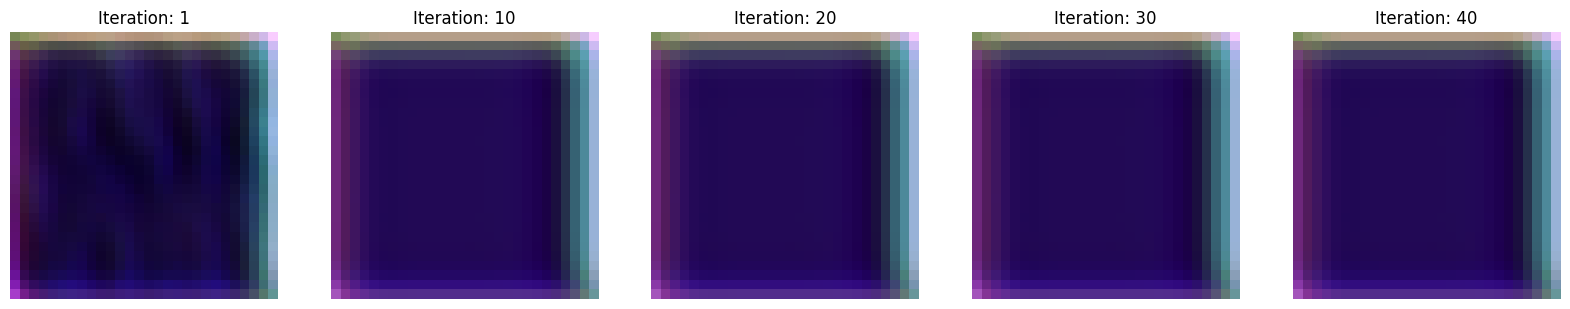

Epoch 300, Loss: 0.01706881821155548


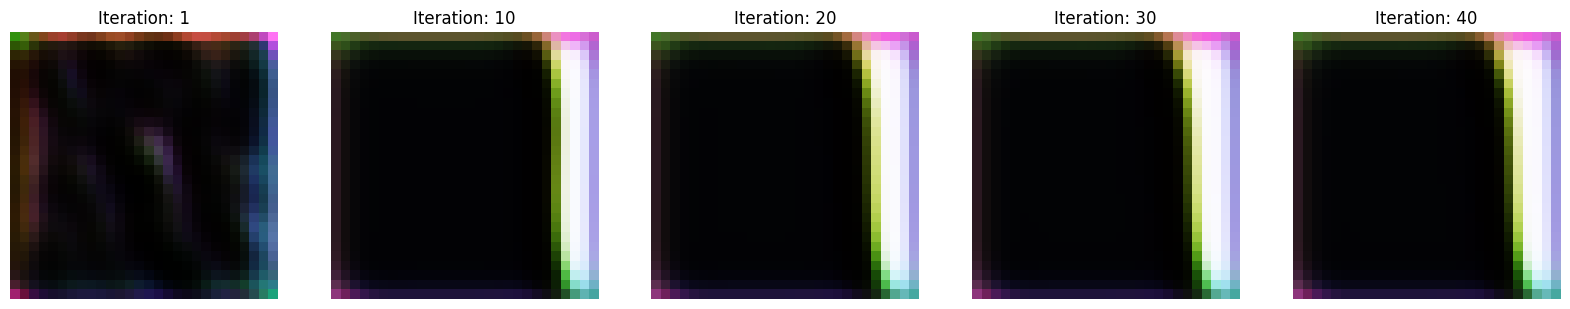

Epoch 400, Loss: 0.0071382075548172


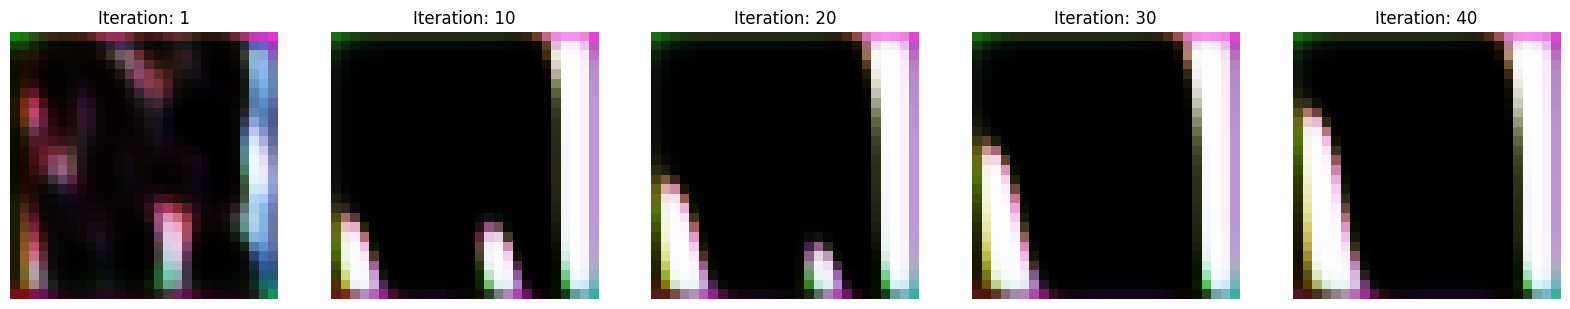

Epoch 500, Loss: 0.004519454203546047


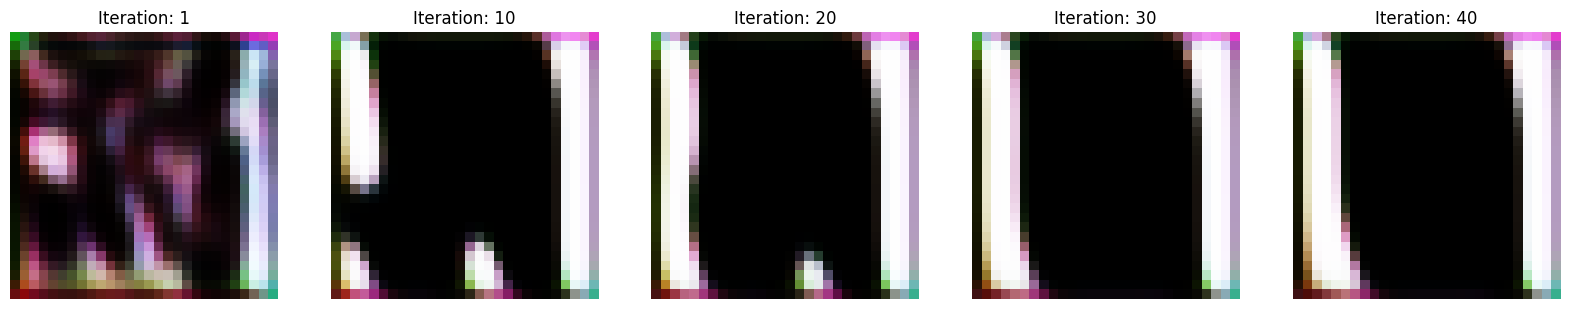

Epoch 600, Loss: 0.003348573809489608


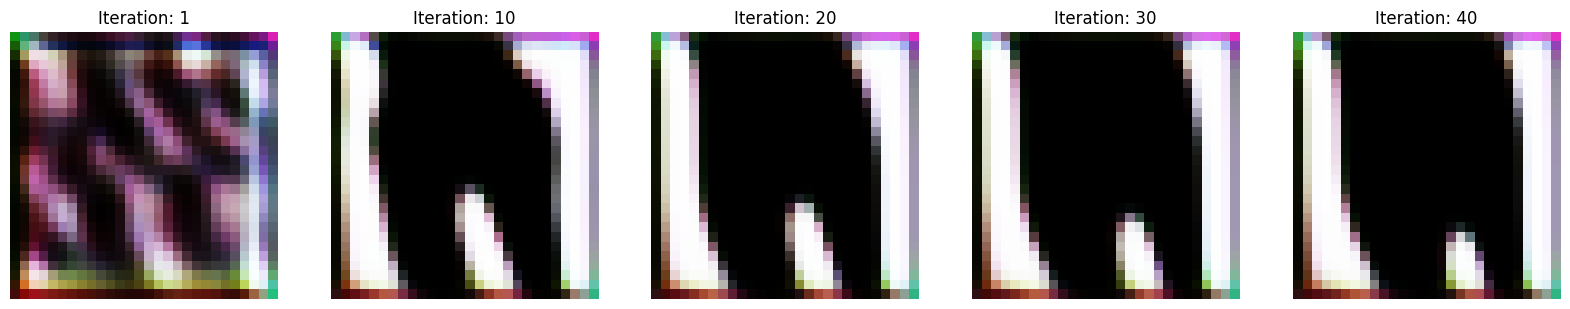

Epoch 700, Loss: 0.0025830231606960297


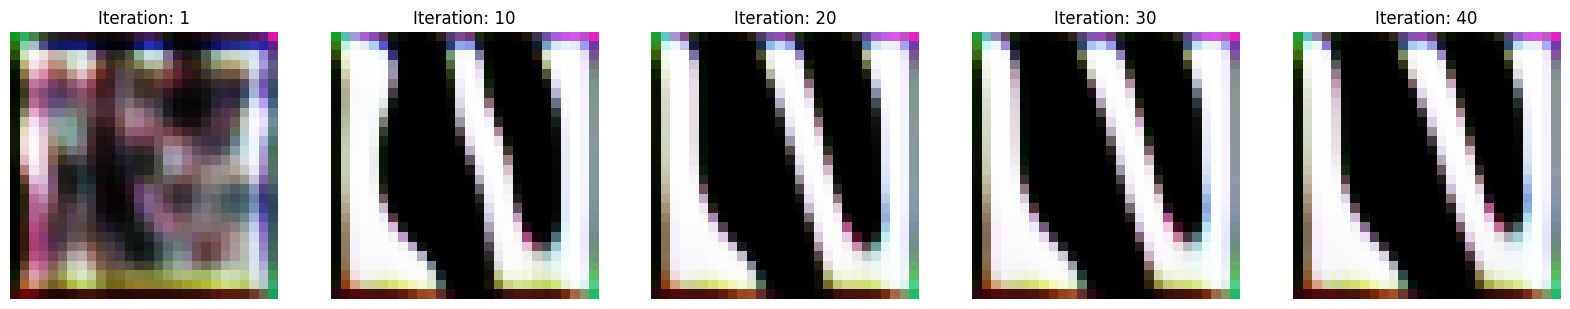

Epoch 800, Loss: 0.002018219791352749


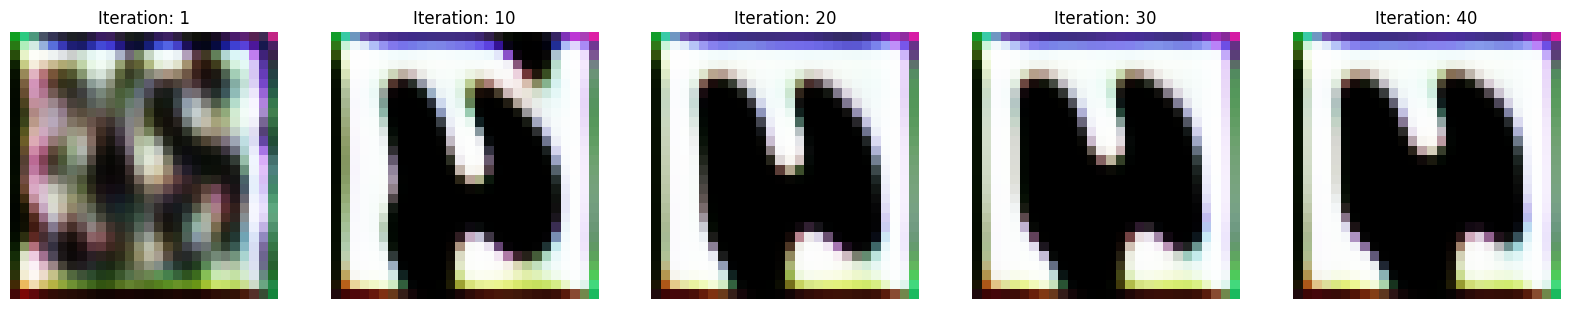

Epoch 900, Loss: 0.0016204201383516192


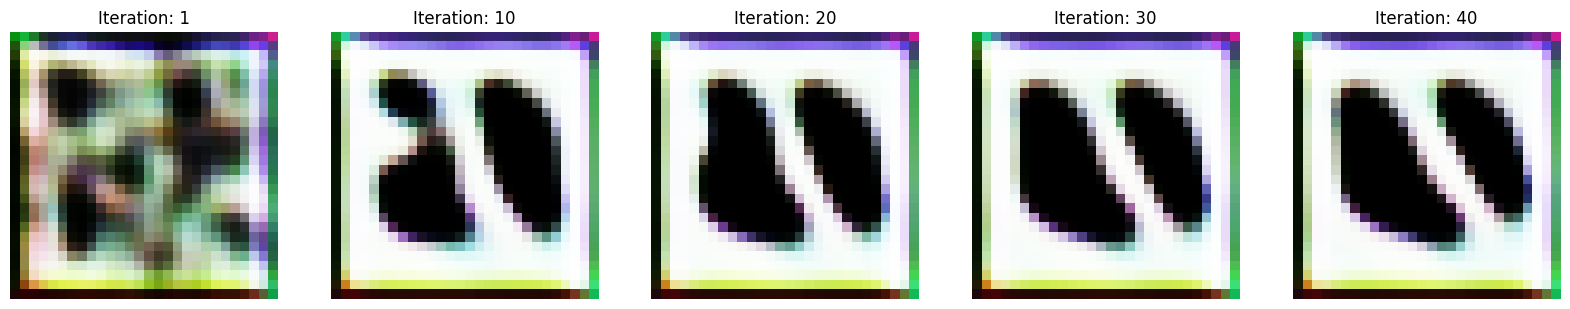

Epoch 1000, Loss: 0.0013238608371466398


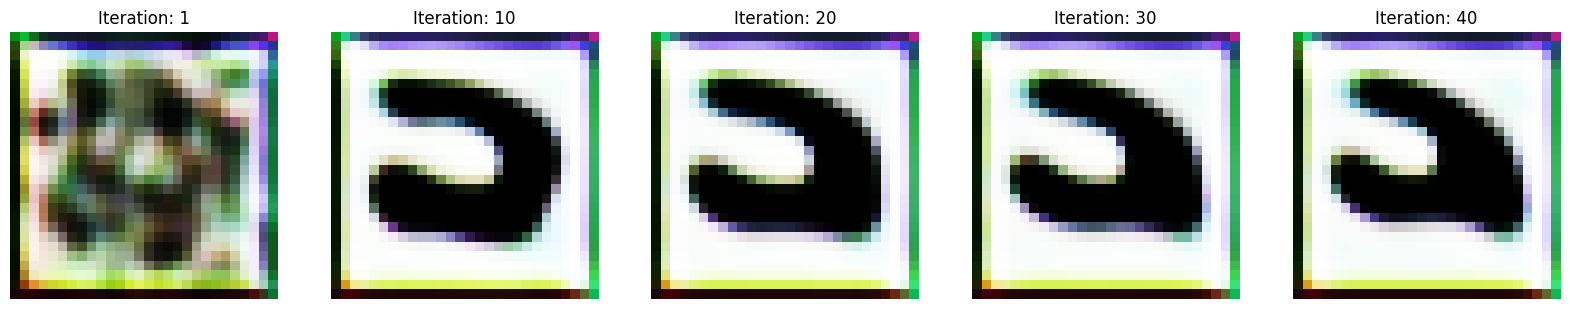

Epoch 1100, Loss: 0.0011151264188811183


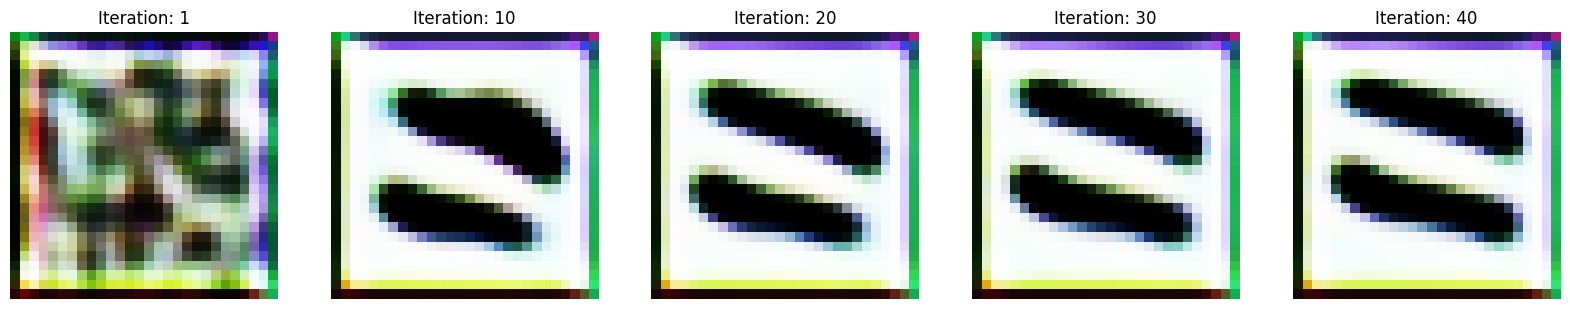

Epoch 1200, Loss: 0.0009693735628388822


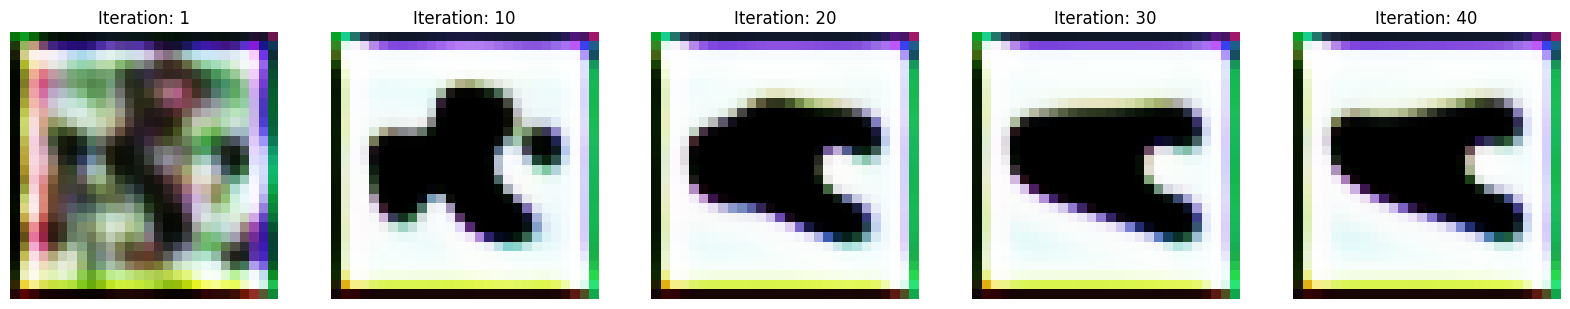

Epoch 1300, Loss: 0.0008585642208345234


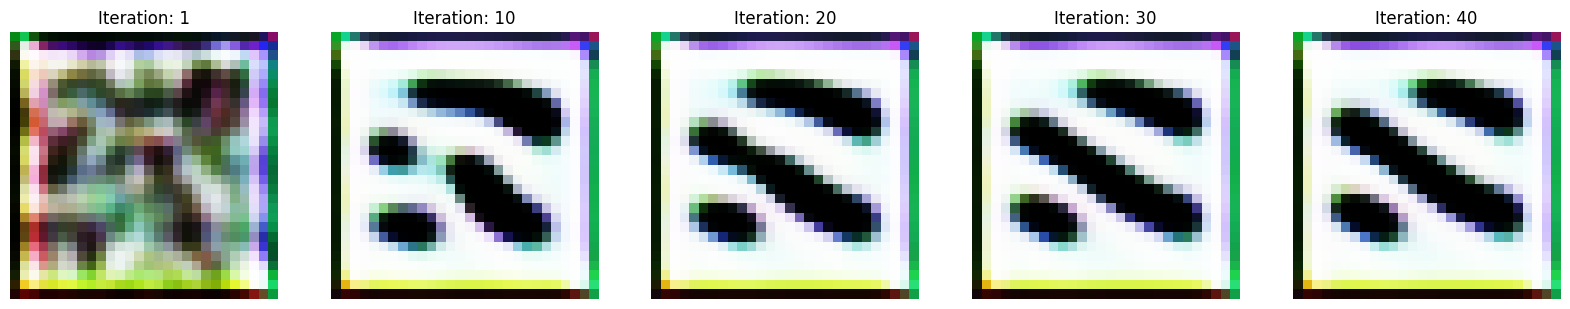

Epoch 1400, Loss: 0.0007540970691479743


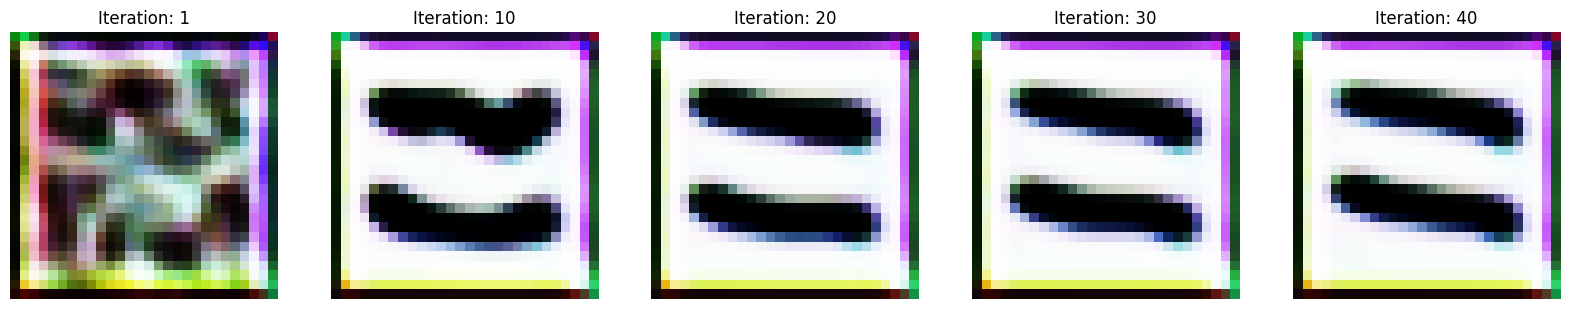

Epoch 1500, Loss: 0.0006702102837152779


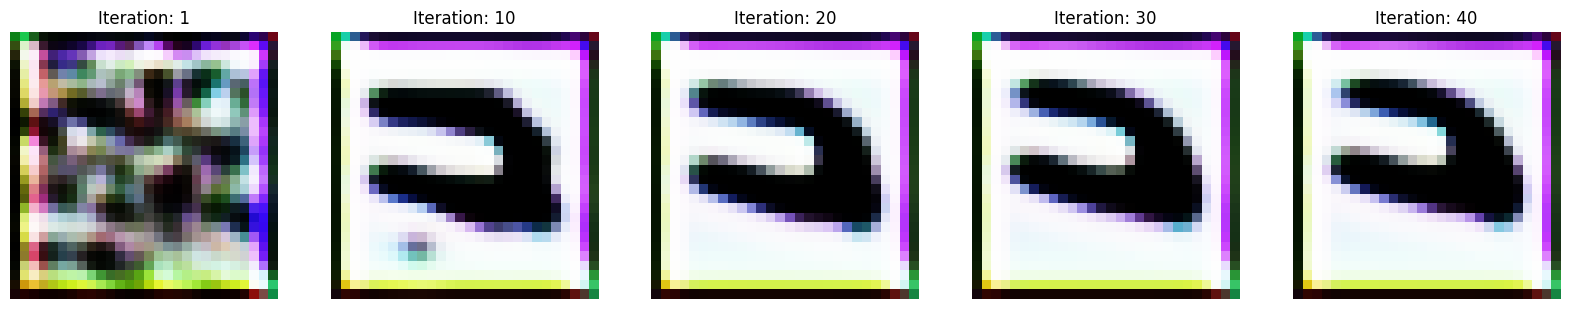

Epoch 1600, Loss: 0.0006088166264817119


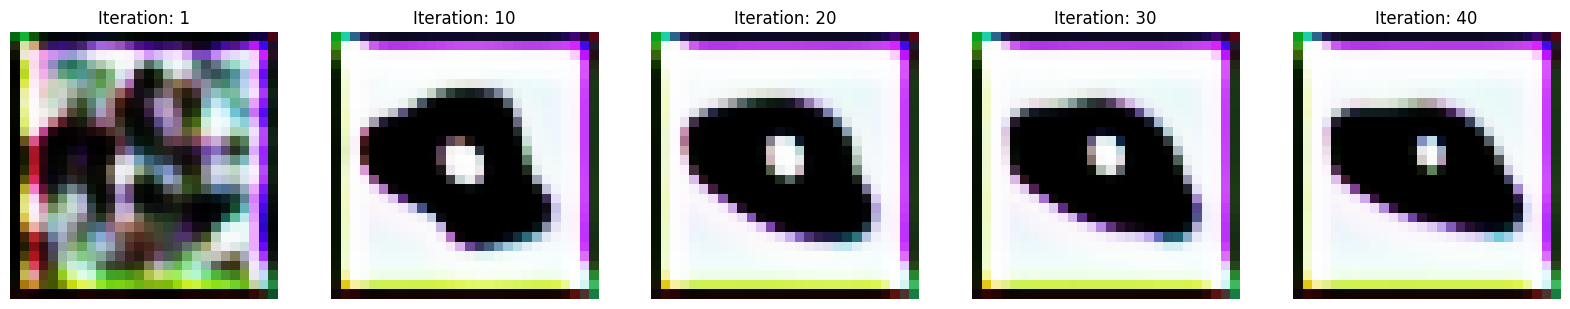

Epoch 1700, Loss: 0.0005534482188522816


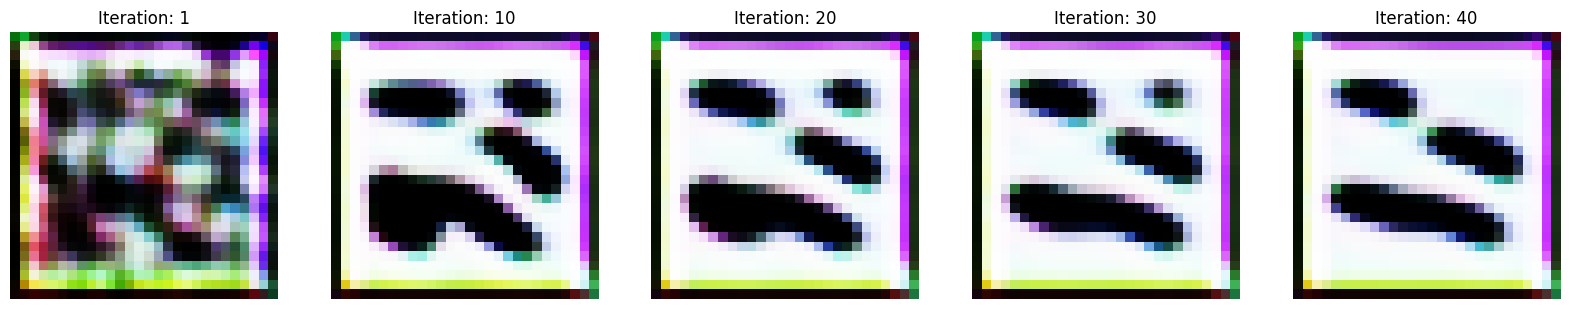

Epoch 1800, Loss: 0.0005032851477153599


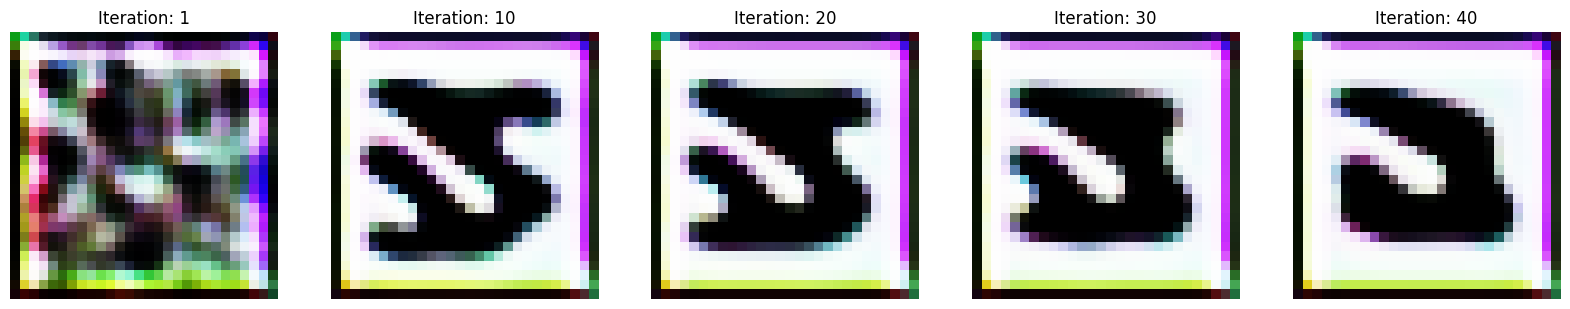

Epoch 1900, Loss: 0.00045827555004507303


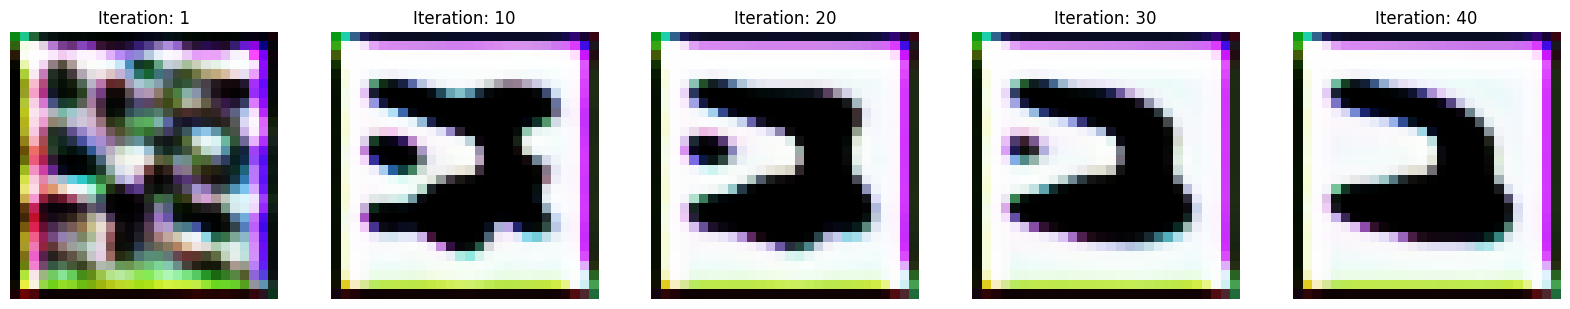

Epoch 2000, Loss: 0.00041587589657865465


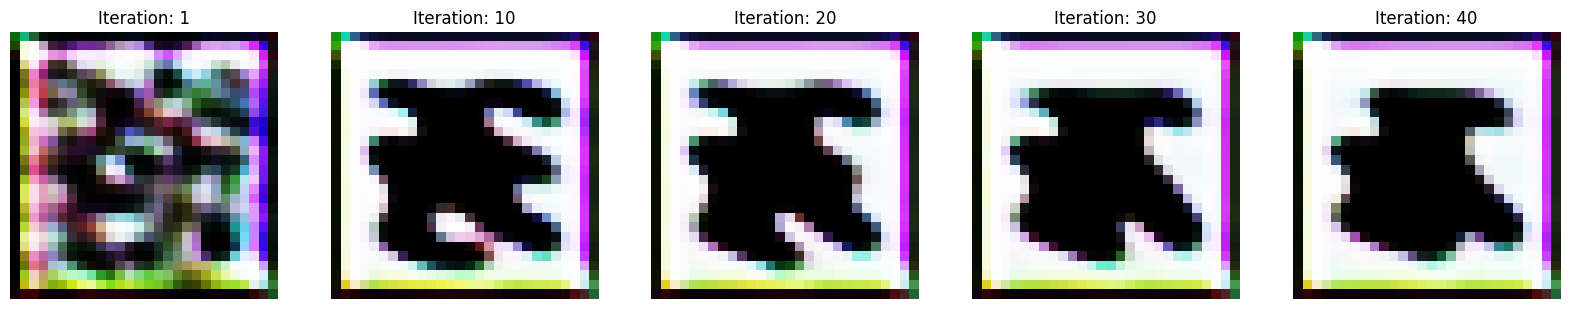

Epoch 2100, Loss: 0.0003793499490711838


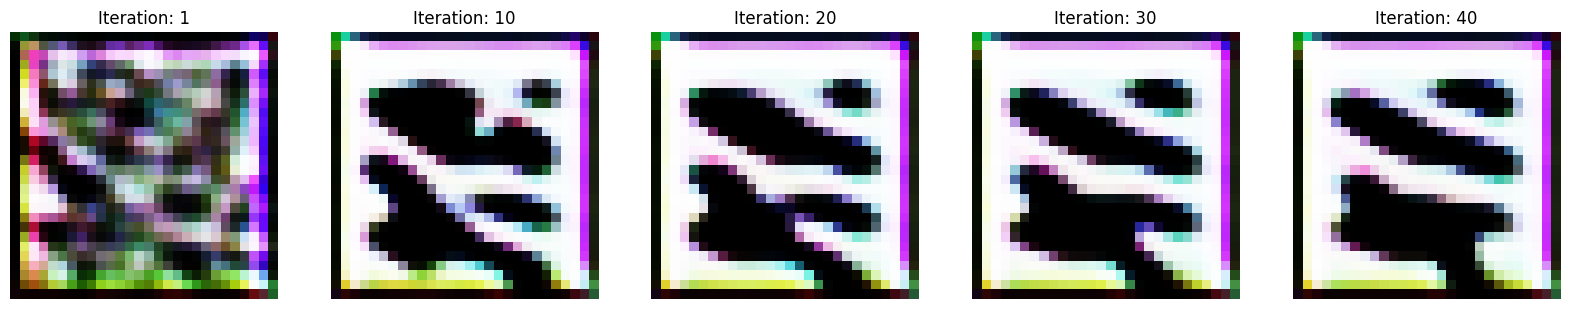

Epoch 2200, Loss: 0.00034815576509572566


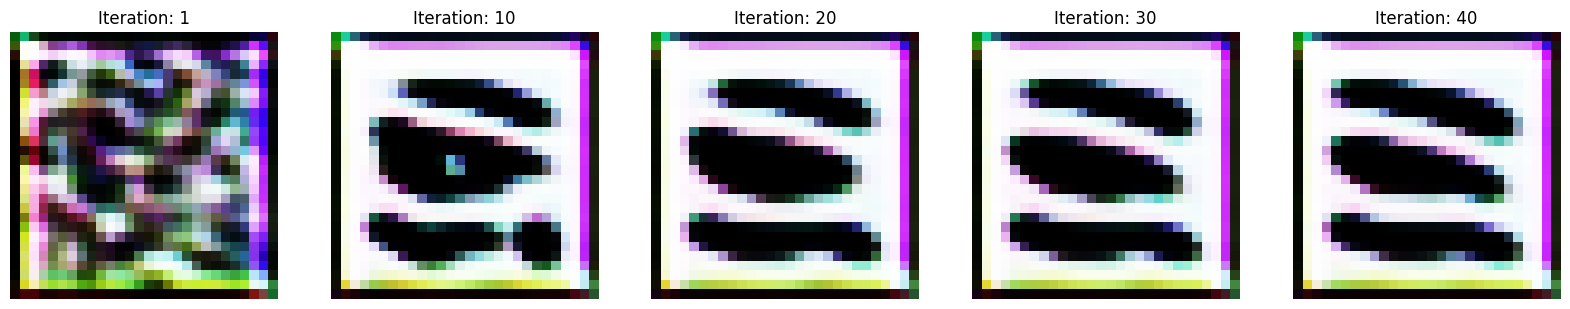

Epoch 2300, Loss: 0.00032160698901861906


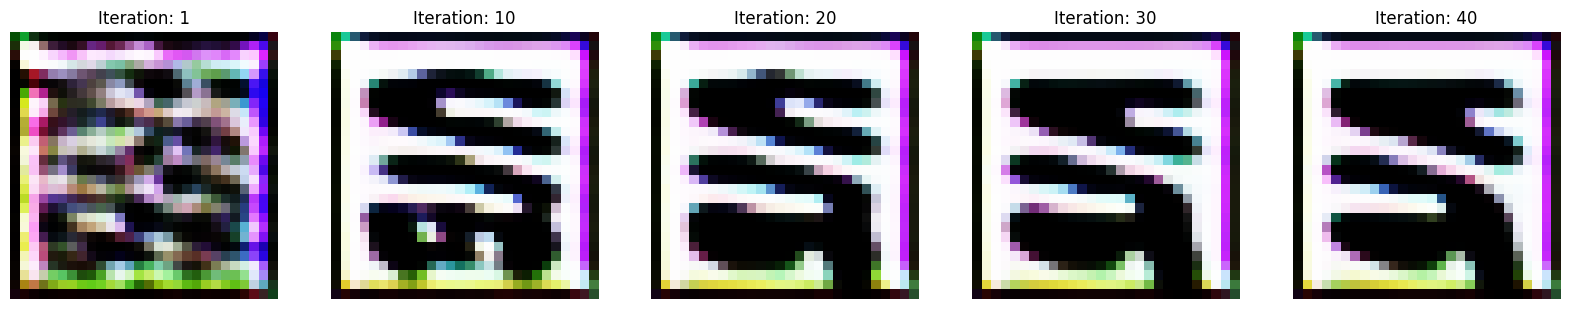

Epoch 2400, Loss: 0.00029842558433301747


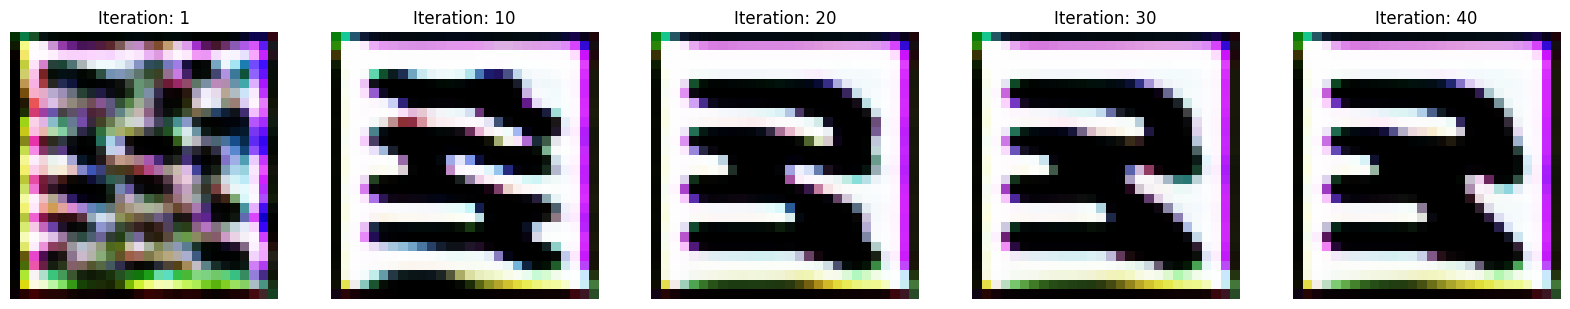

Epoch 2500, Loss: 0.0002779933565761894


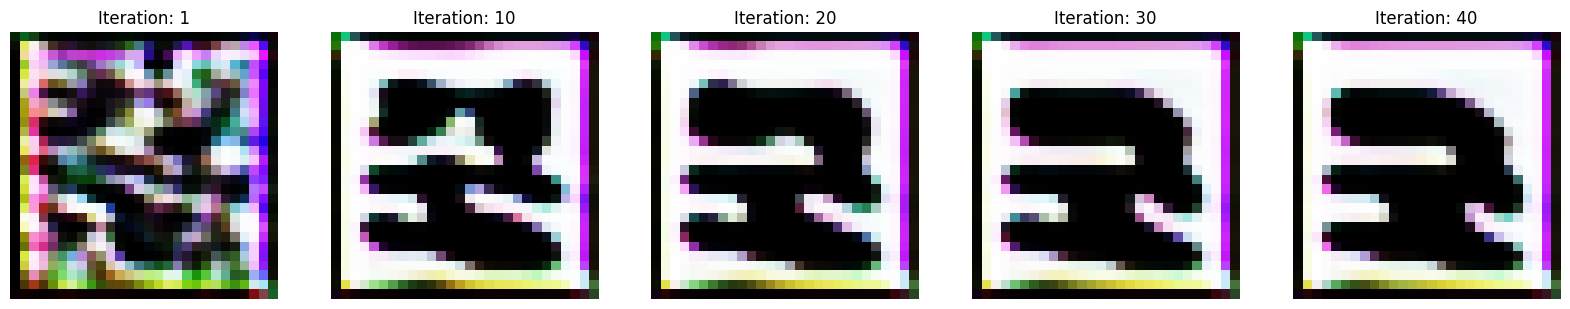

Epoch 2600, Loss: 0.0002596368722151965


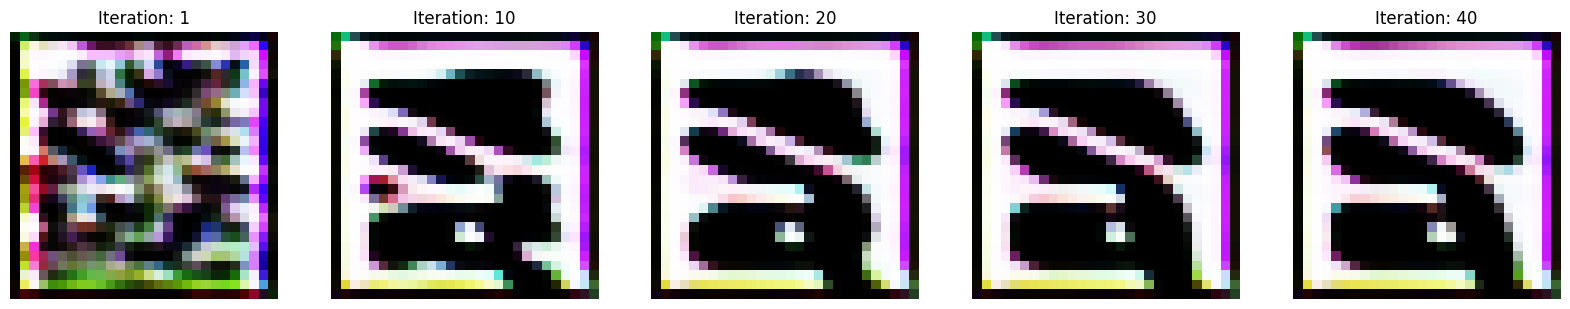

Epoch 2700, Loss: 0.00024272895825561136


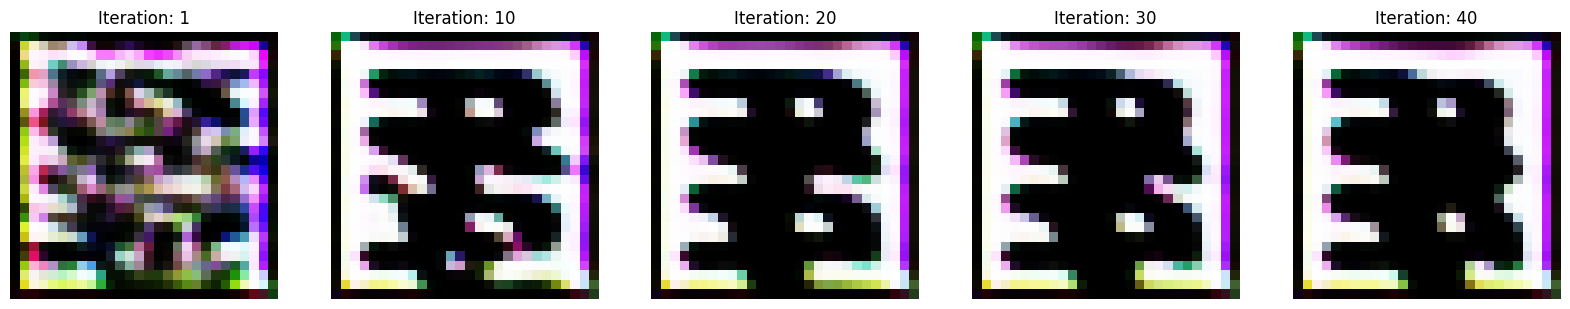

Epoch 2800, Loss: 0.00022714406077284366


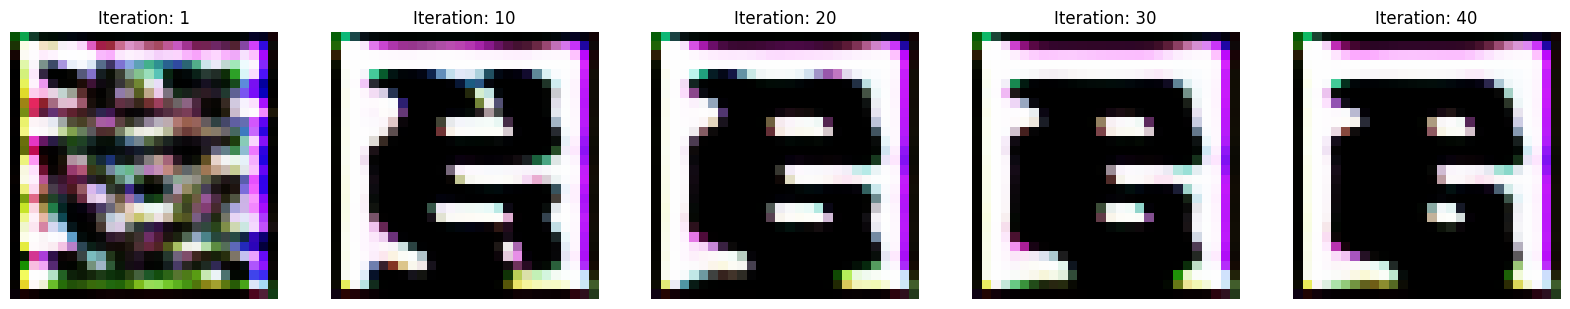

Epoch 2900, Loss: 0.00021302250388544053


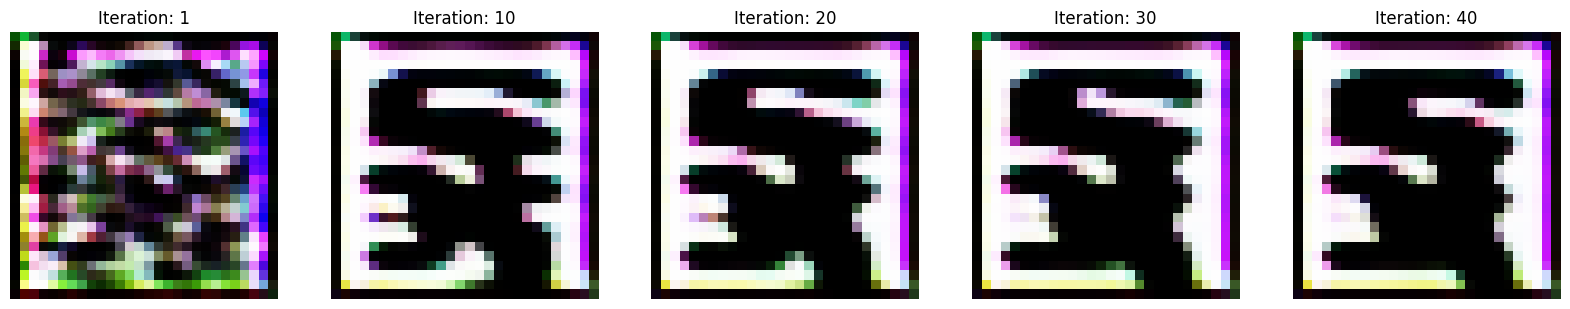

Epoch 3000, Loss: 0.00020019878866150975


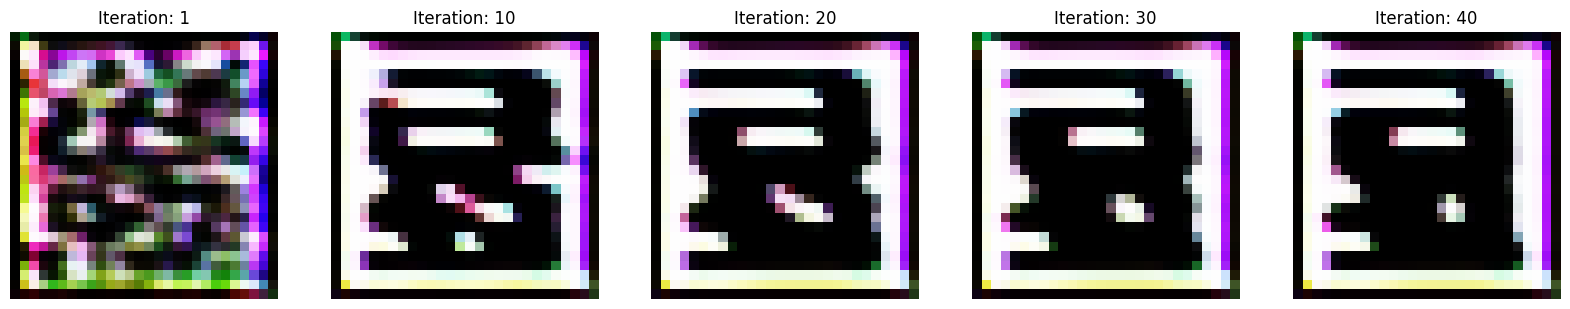

Epoch 3100, Loss: 0.0001885148958535865


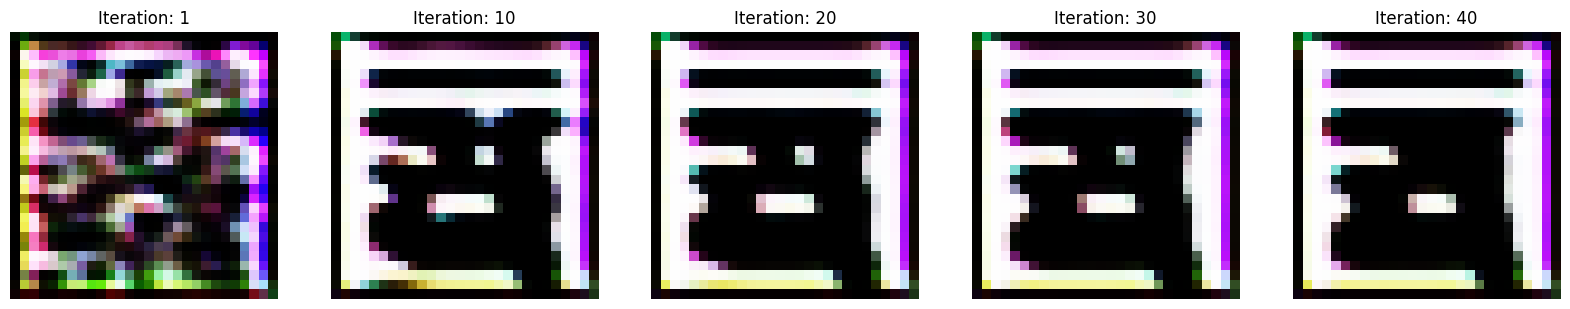

Epoch 3200, Loss: 0.0001776273566065356


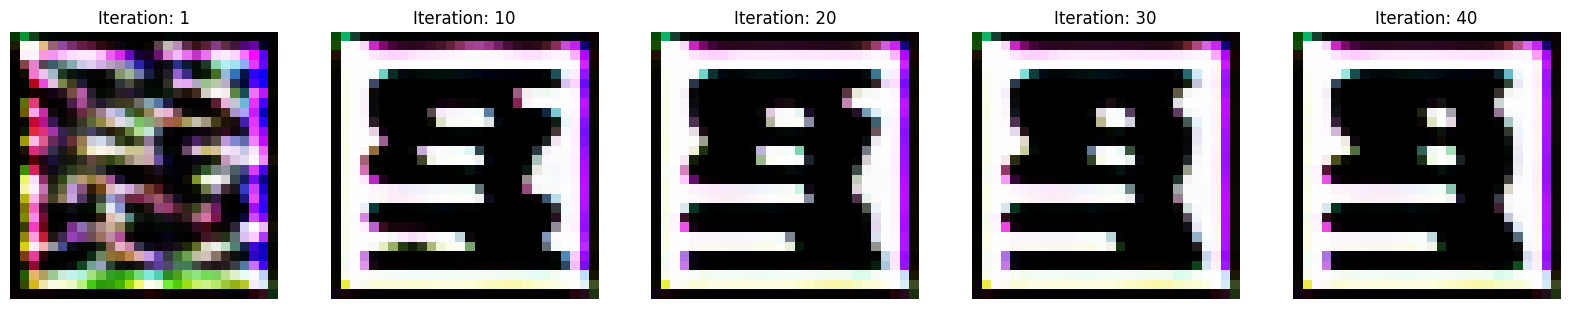

Epoch 3300, Loss: 0.0001682335278019309


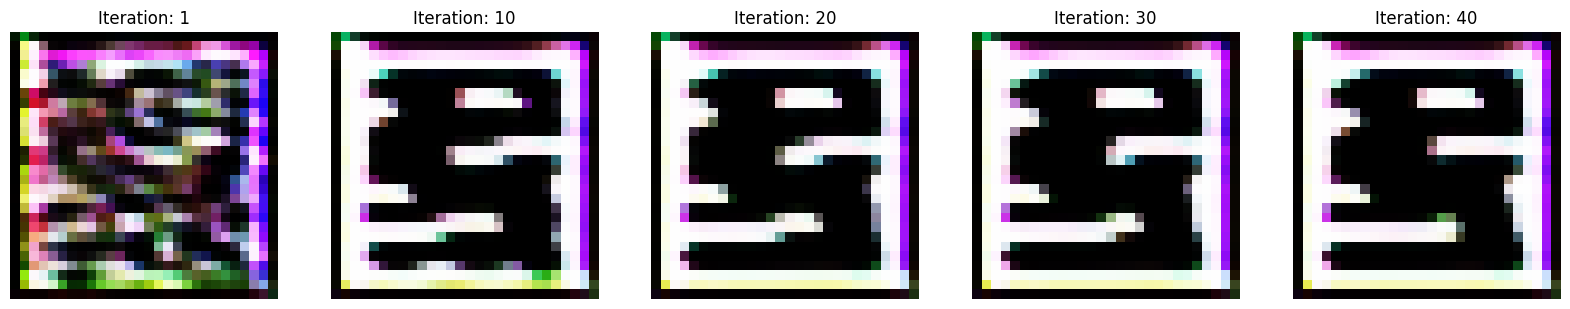

Epoch 3400, Loss: 0.00015959137817844748


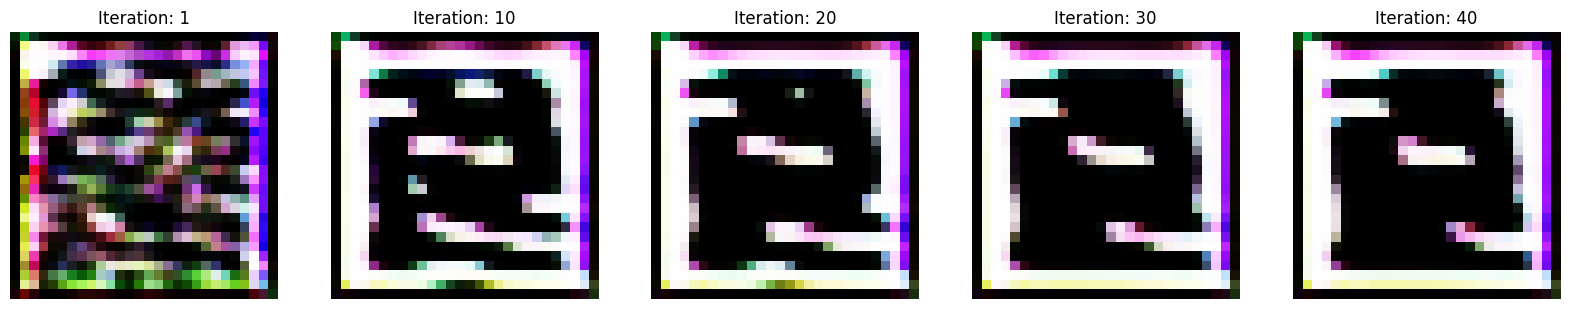

Epoch 3500, Loss: 0.000151464540977031


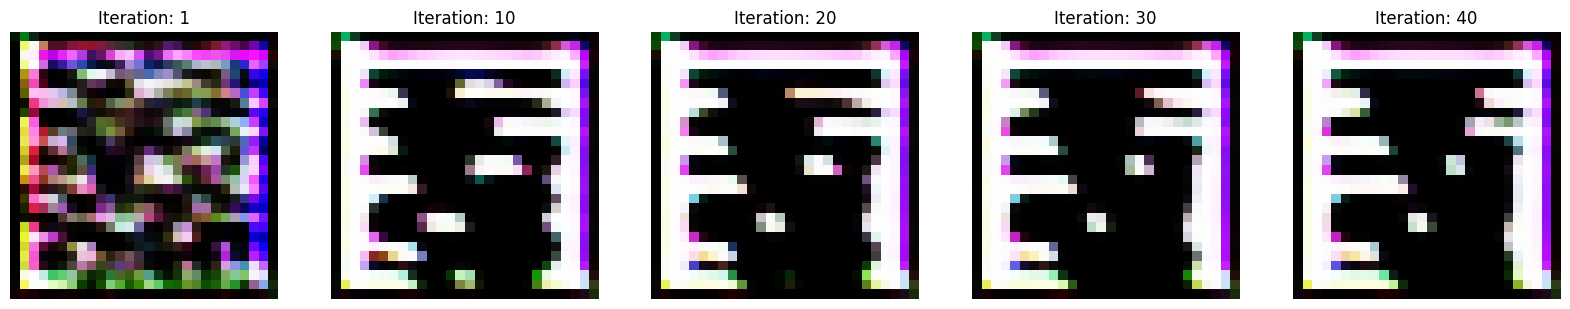

Epoch 3600, Loss: 0.00014414706674870104


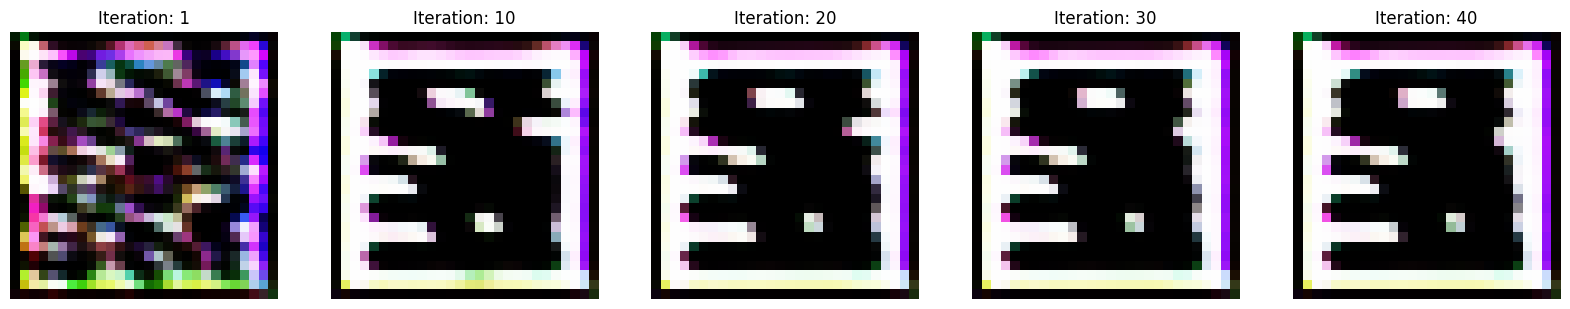

Epoch 3700, Loss: 0.00013735027459915727


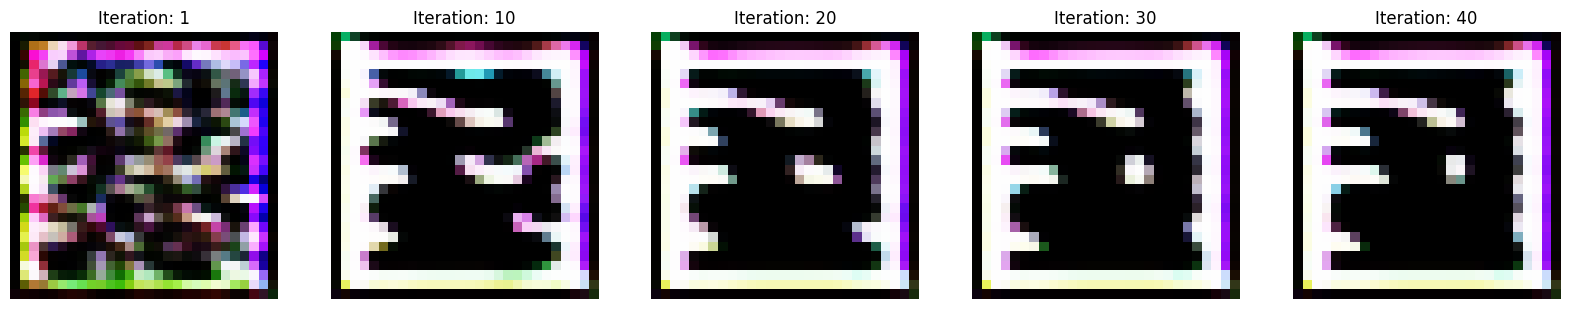

Epoch 3800, Loss: 0.0001309060608036816


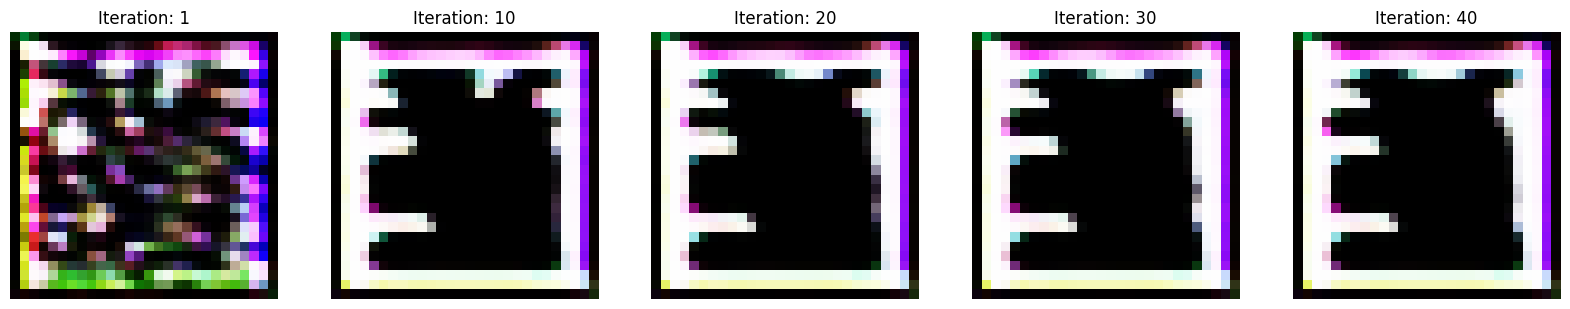

Epoch 3900, Loss: 0.00012475255061872303


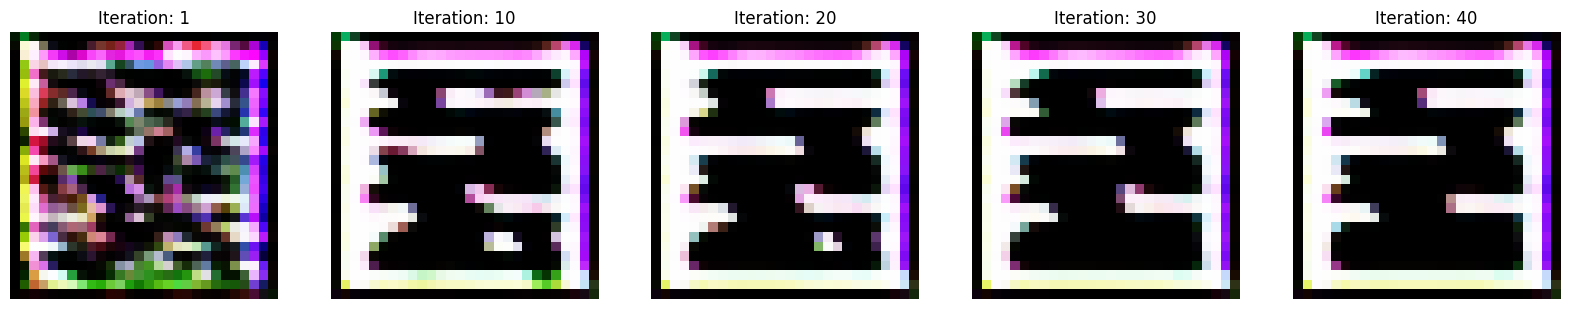

Epoch 4000, Loss: 0.00011916162475245073


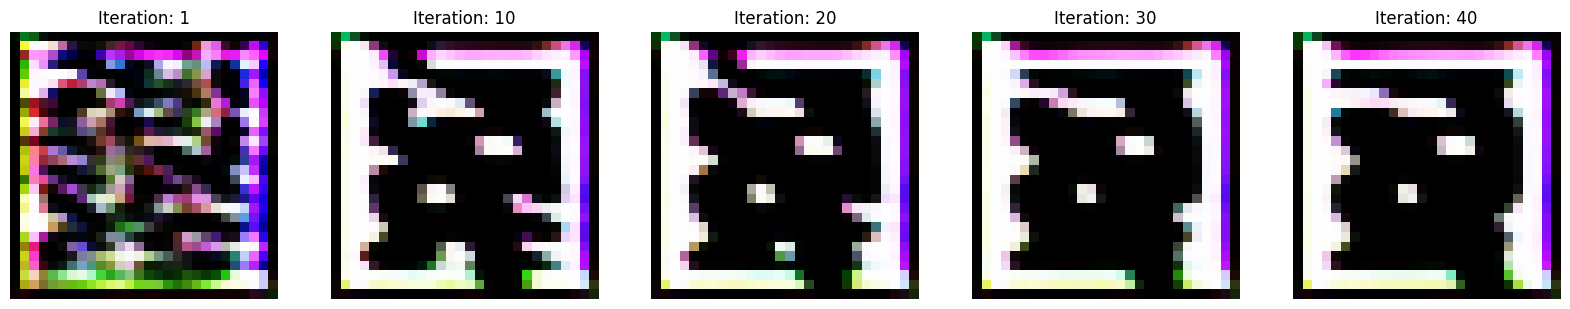

Epoch 4100, Loss: 0.00011401189112802967


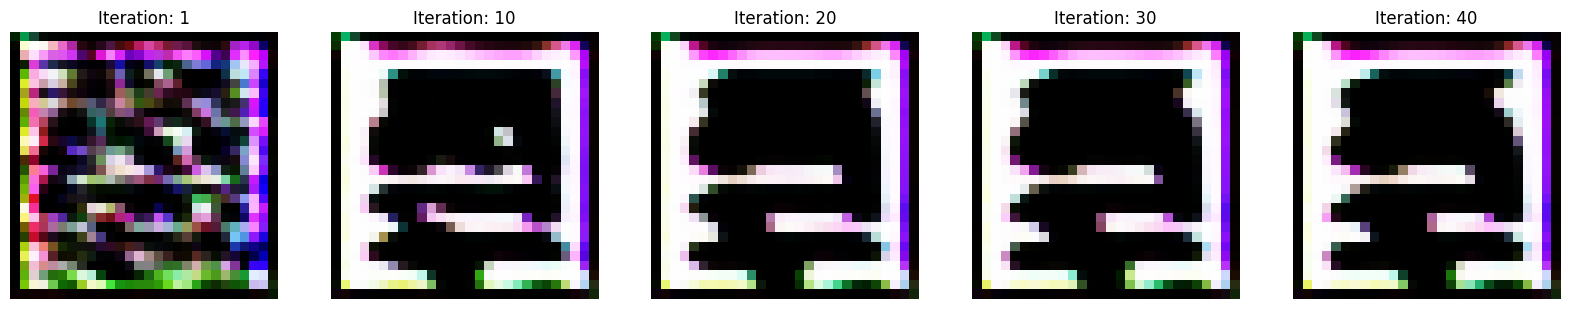

Epoch 4200, Loss: 0.00010921835928456858


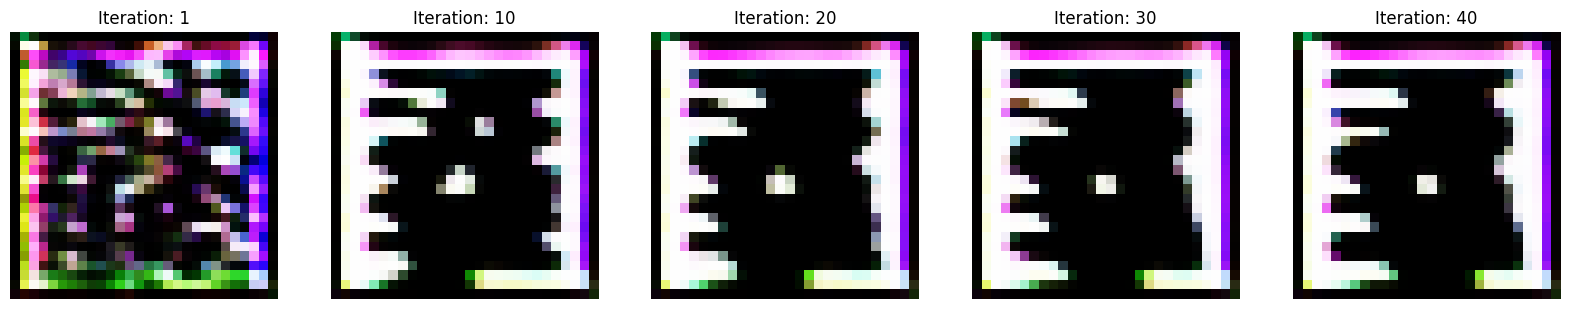

Epoch 4300, Loss: 0.0001047839323291555


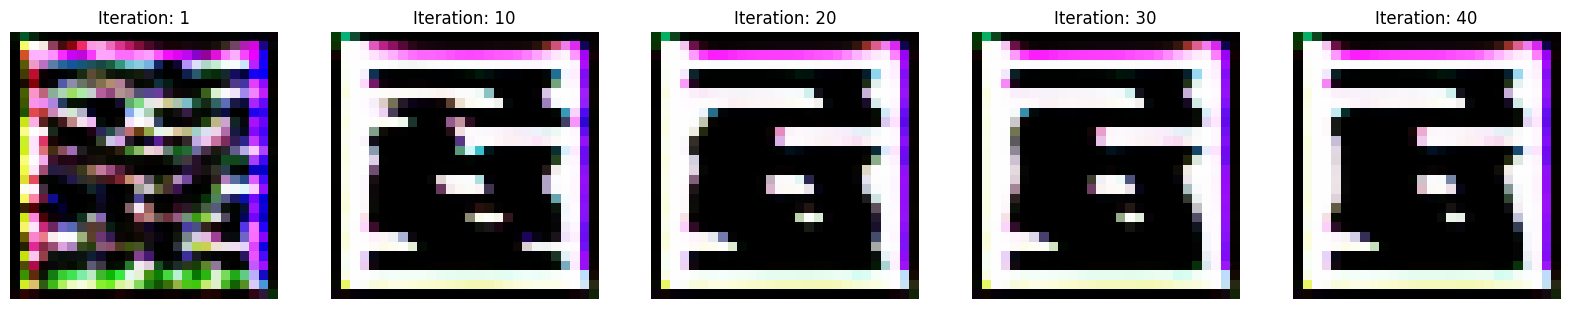

Epoch 4400, Loss: 0.00010055380698759109


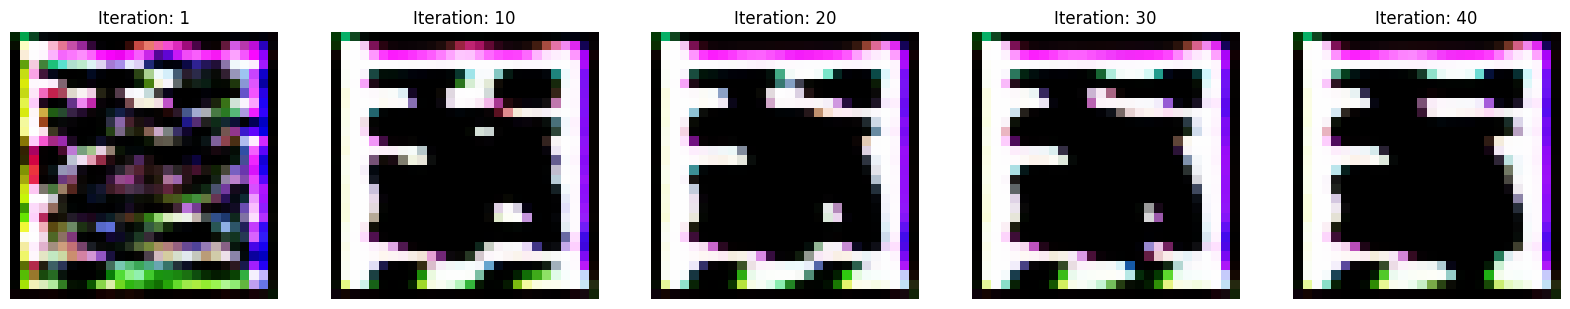

Epoch 4500, Loss: 9.660833165980875e-05


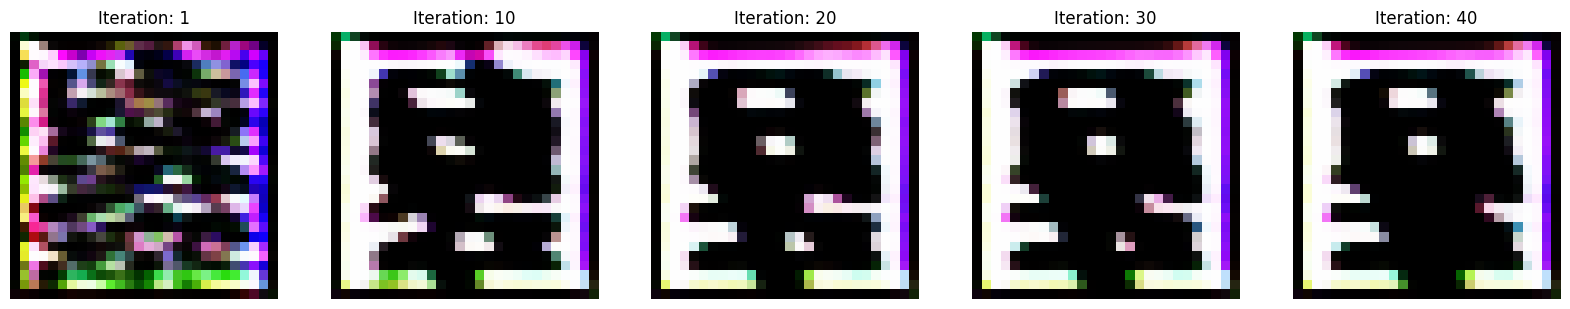

Epoch 4600, Loss: 9.299360681325197e-05


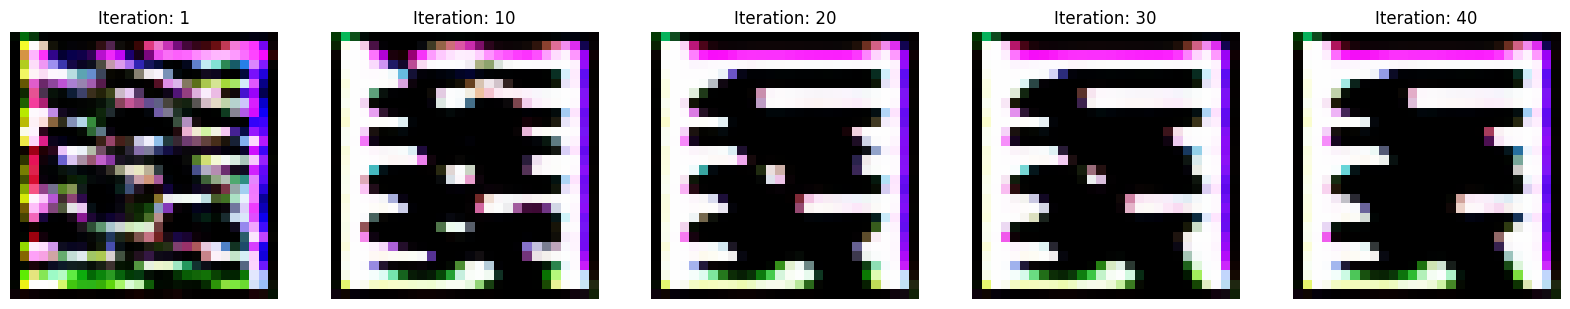

Epoch 4700, Loss: 8.962837455328554e-05


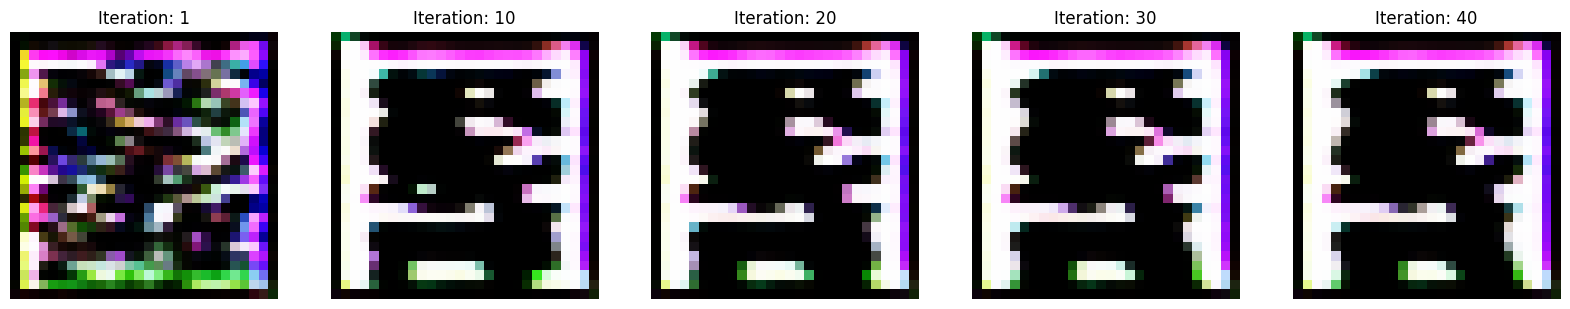

Epoch 4800, Loss: 8.655826968606561e-05


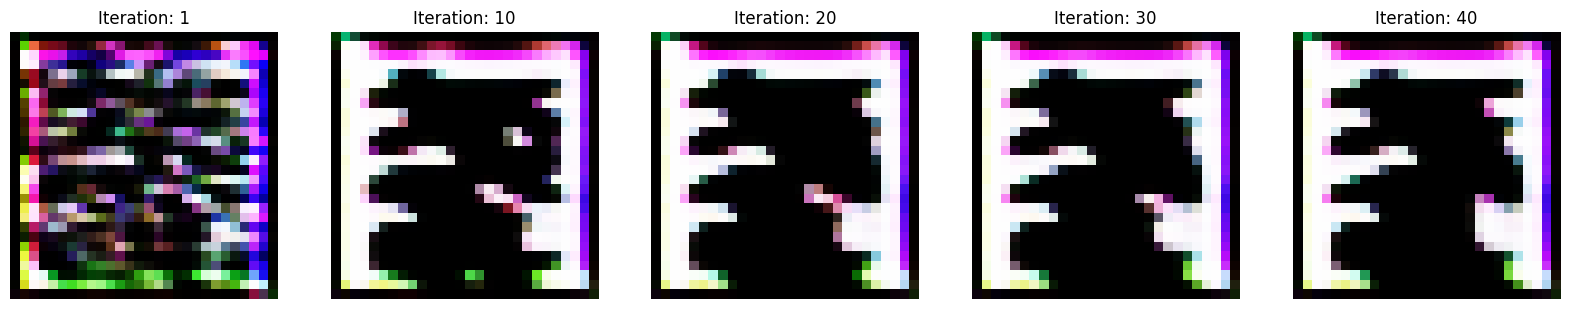

Epoch 4900, Loss: 8.383562817471102e-05


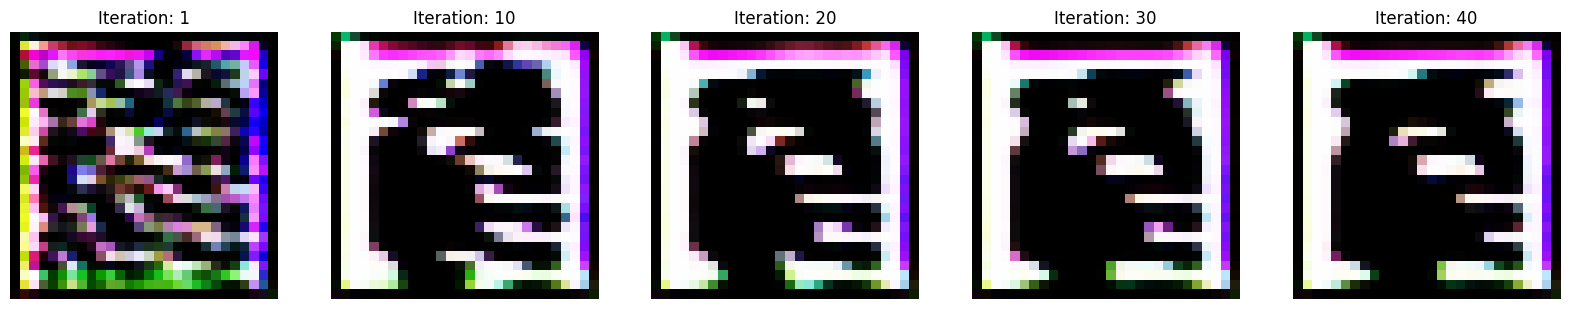

Epoch 5000, Loss: 8.100850391201675e-05


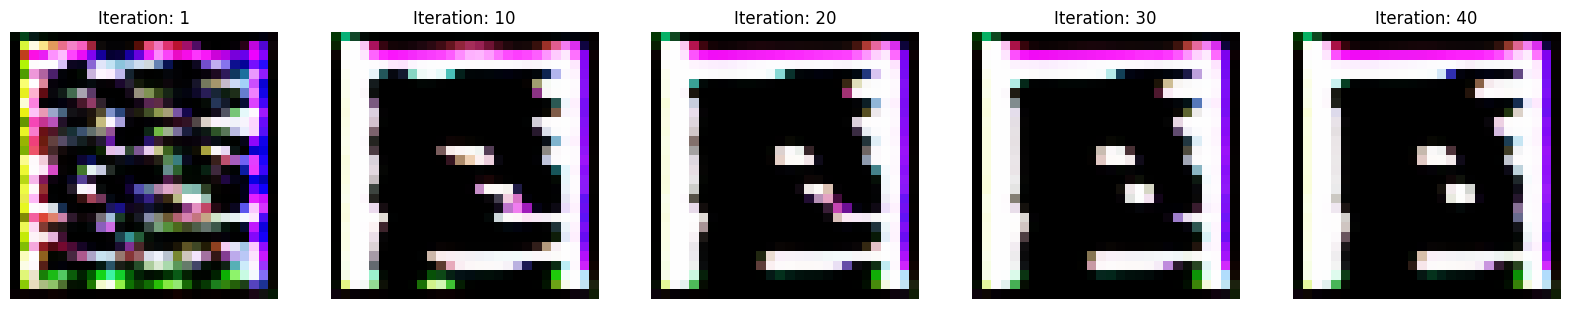

Epoch 5100, Loss: 7.853512215660885e-05


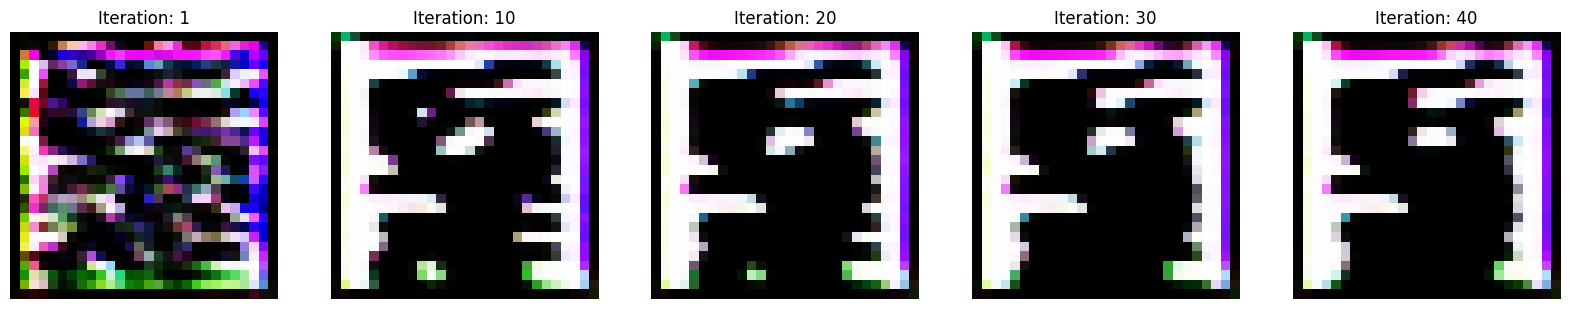

Epoch 5200, Loss: 7.648684550076723e-05


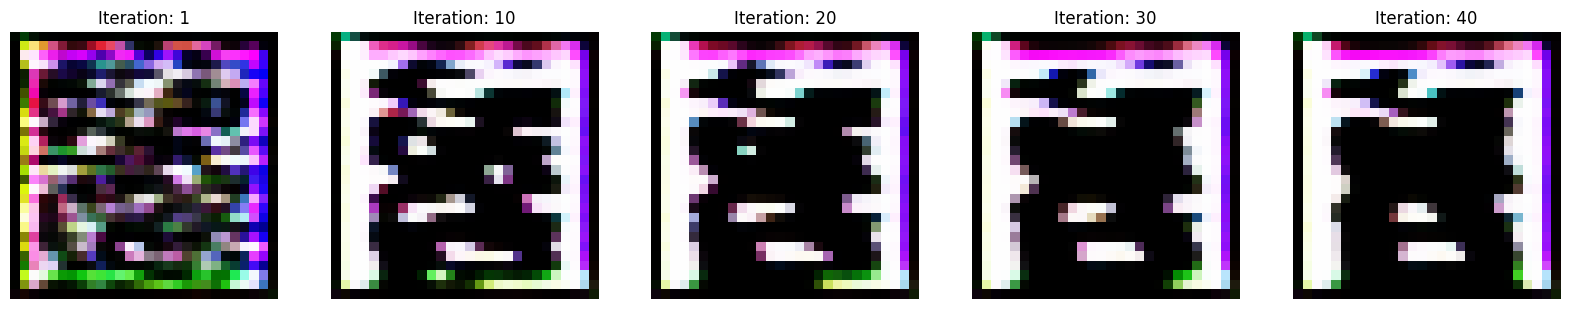

Epoch 5300, Loss: 7.41353869671002e-05


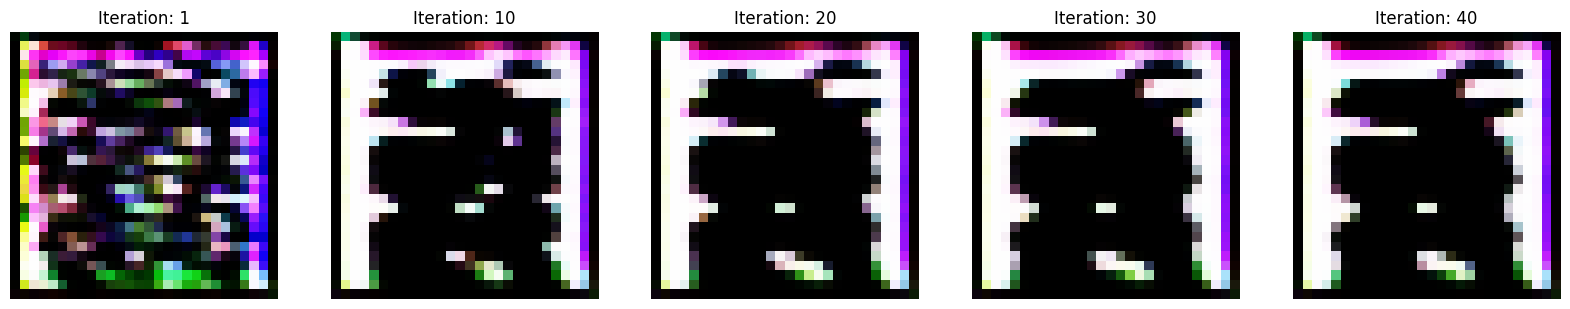

Epoch 5400, Loss: 7.215648656710982e-05


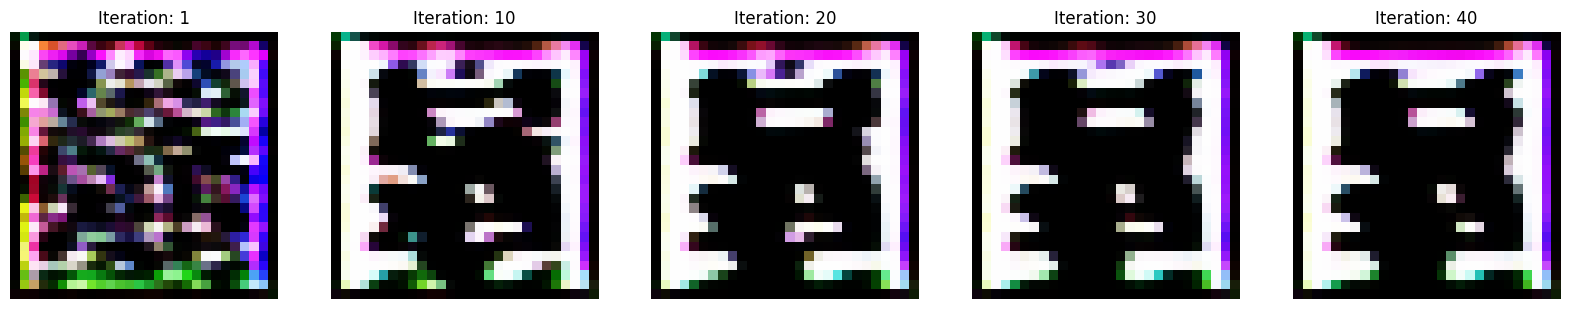

Epoch 5500, Loss: 7.035284215817228e-05


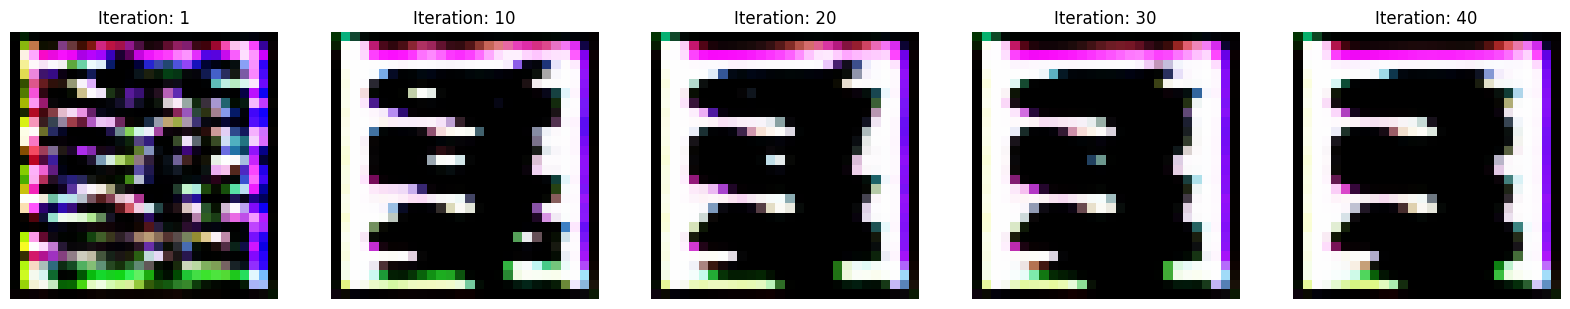

Epoch 5600, Loss: 6.85149134369567e-05


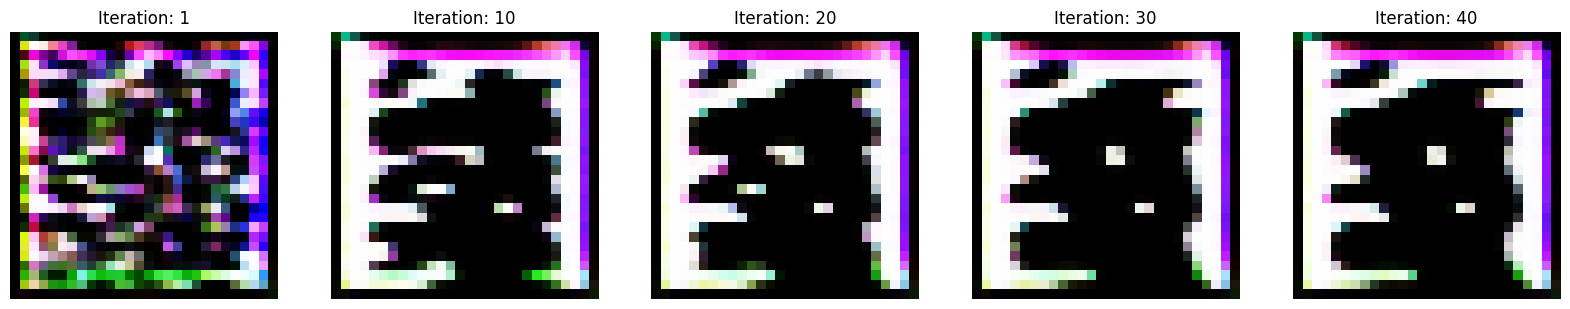

Epoch 5700, Loss: 6.712148024234921e-05


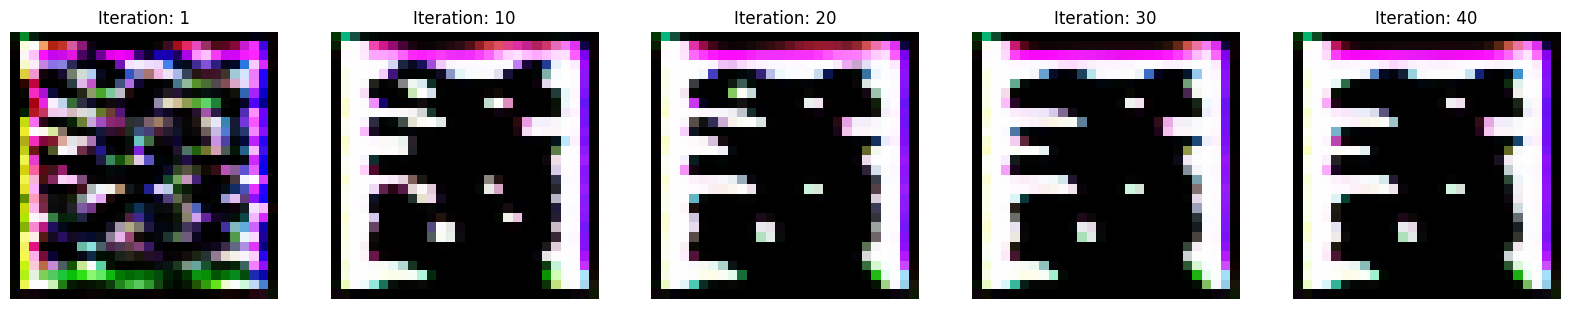

Epoch 5800, Loss: 6.5517051552888e-05


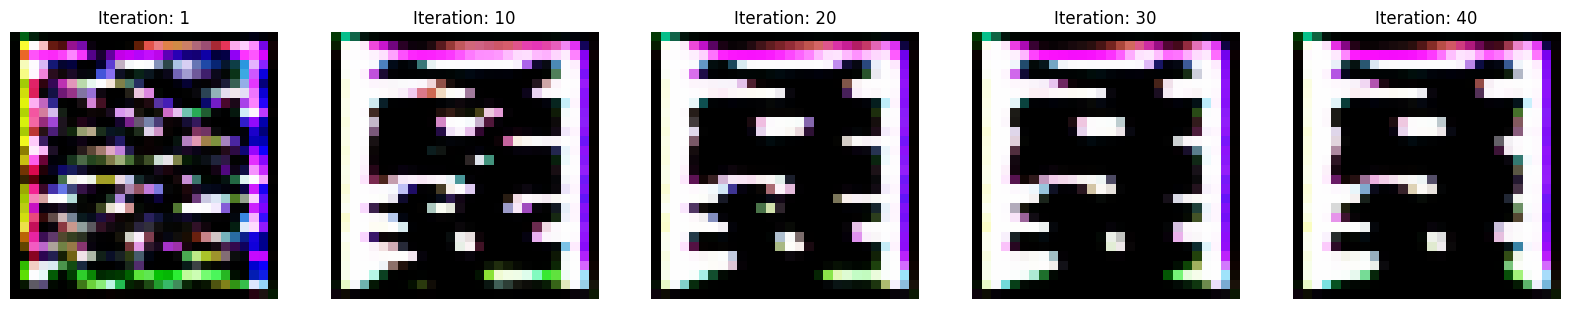

Epoch 5900, Loss: 6.378183752531186e-05


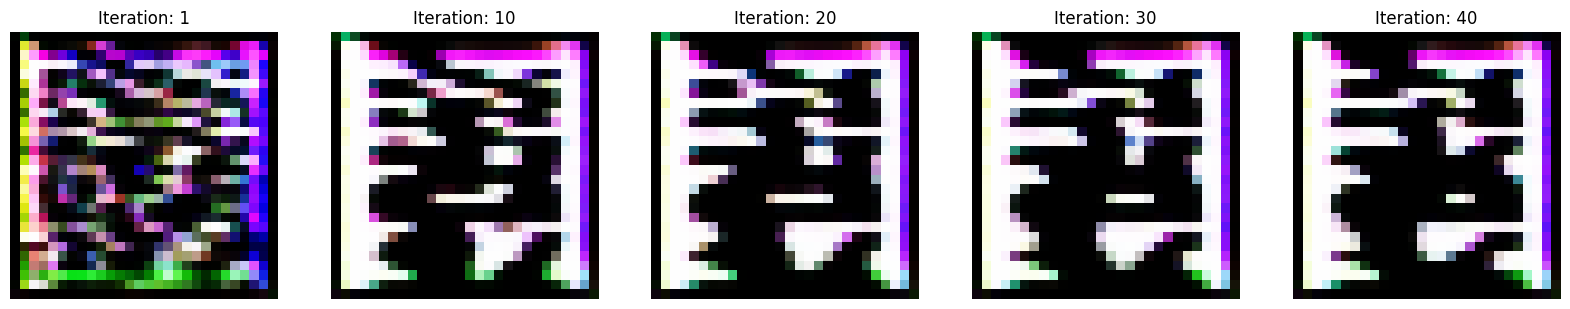

Epoch 6000, Loss: 6.239280628506094e-05


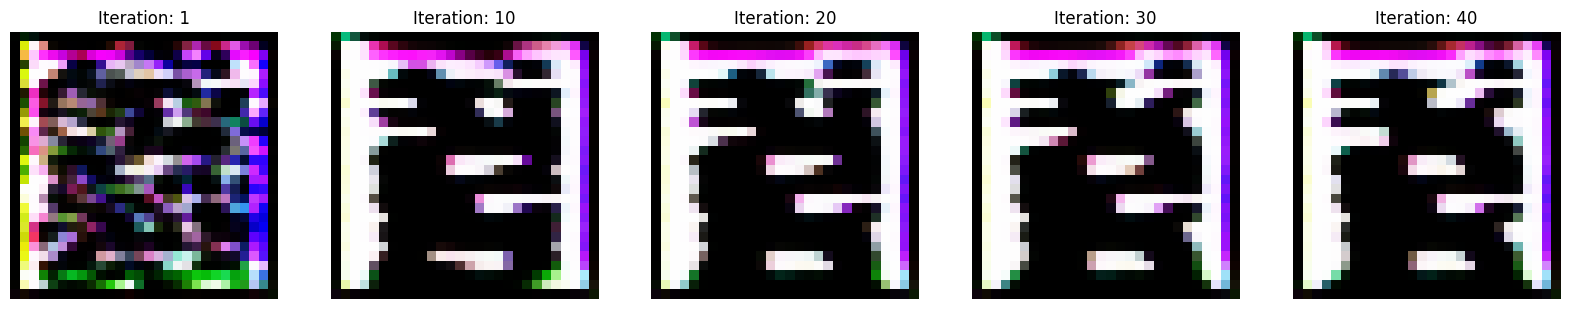

Epoch 6100, Loss: 6.108279922045767e-05


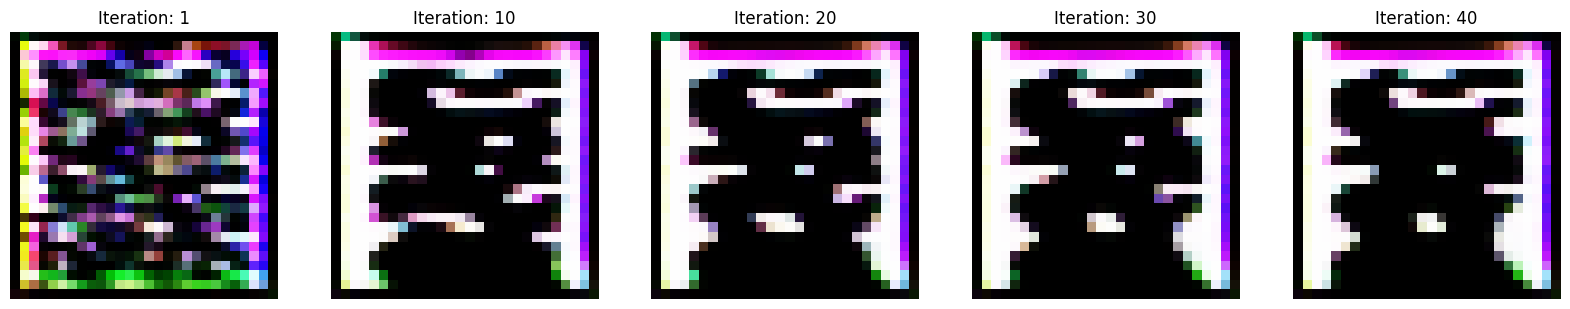

Epoch 6200, Loss: 5.9740905271610245e-05


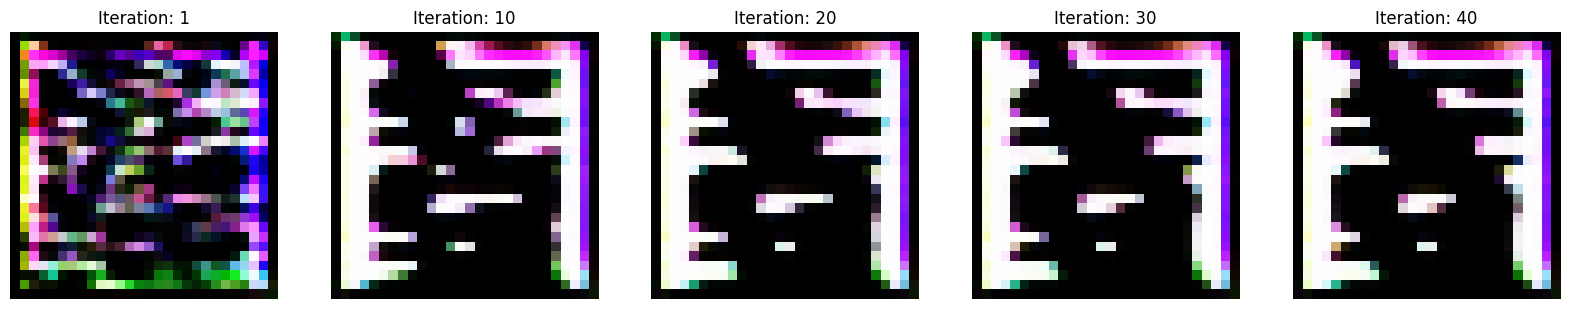

Epoch 6300, Loss: 5.865399361937307e-05


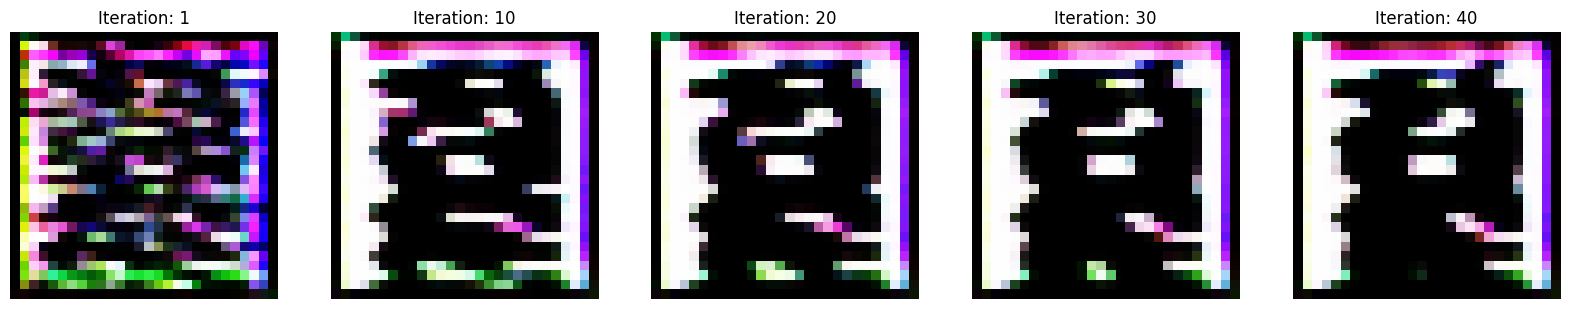

Epoch 6400, Loss: 5.7437144278082997e-05


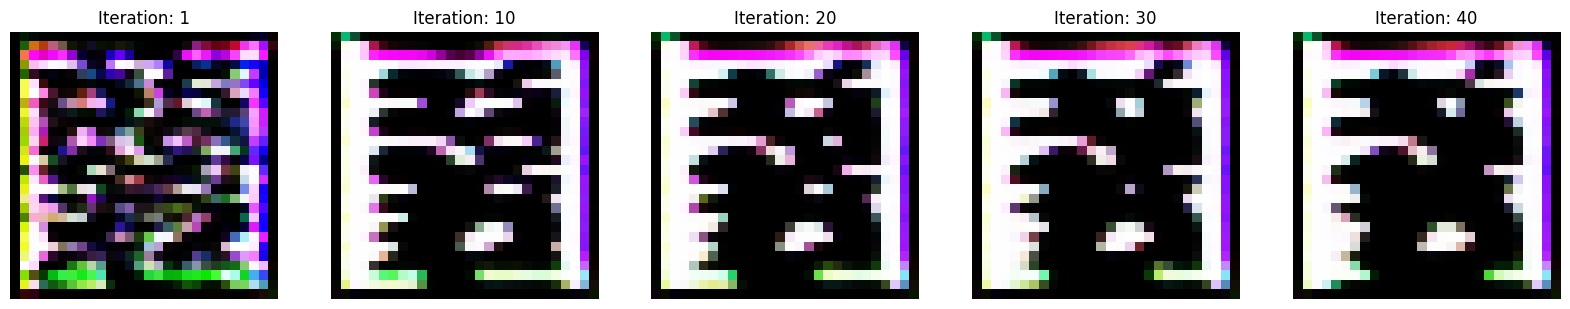

Epoch 6500, Loss: 5.638958828058094e-05


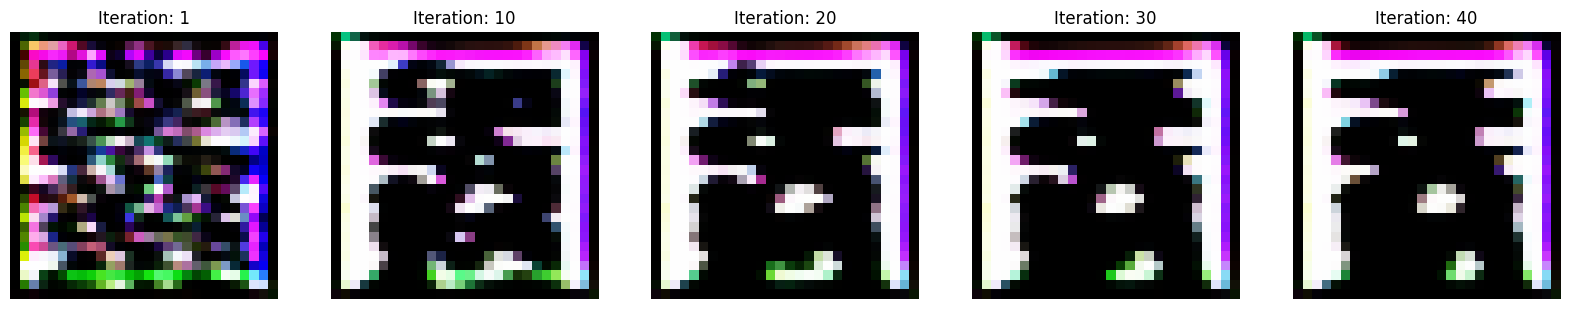

Epoch 6600, Loss: 5.512477218871936e-05


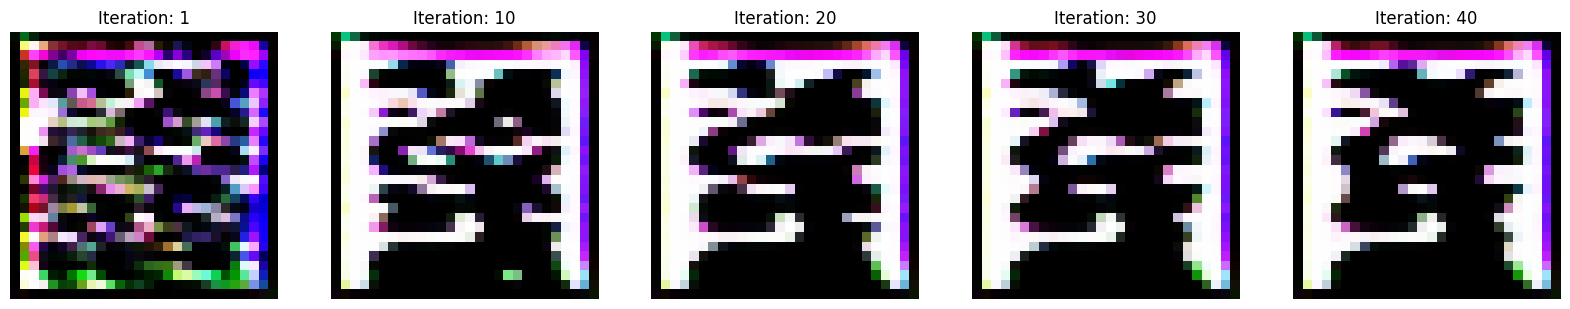

Epoch 6700, Loss: 5.47839081264101e-05


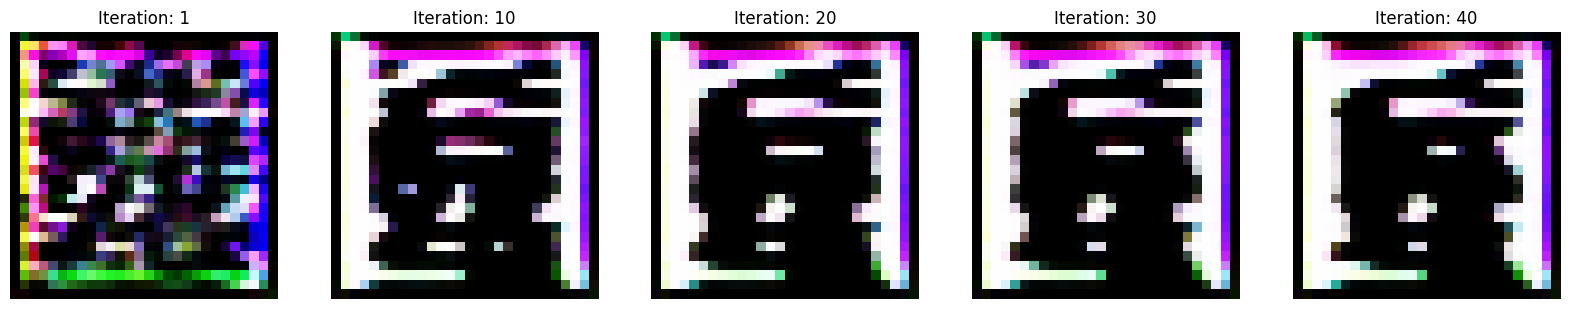

Epoch 6800, Loss: 5.304217847879045e-05


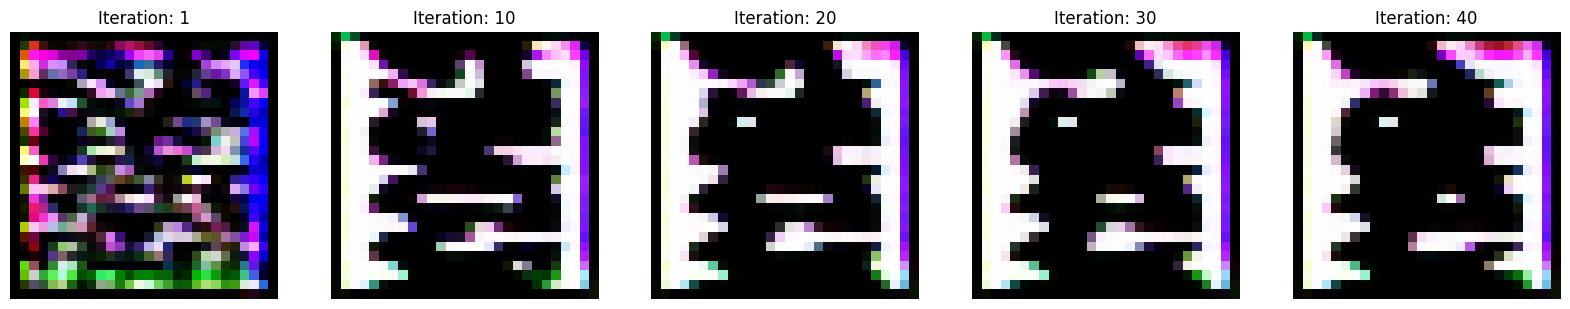

Epoch 6900, Loss: 5.228710506344214e-05


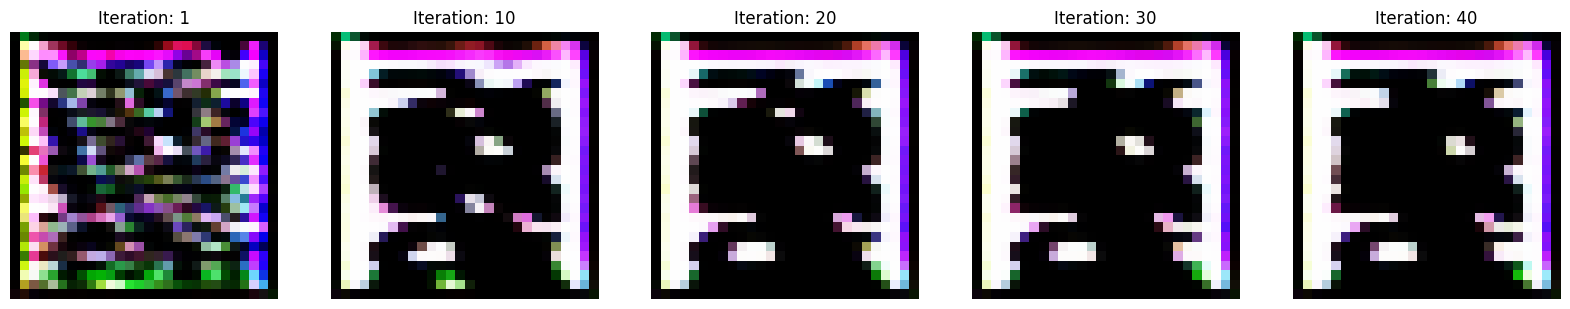

Epoch 7000, Loss: 5.139387940289453e-05


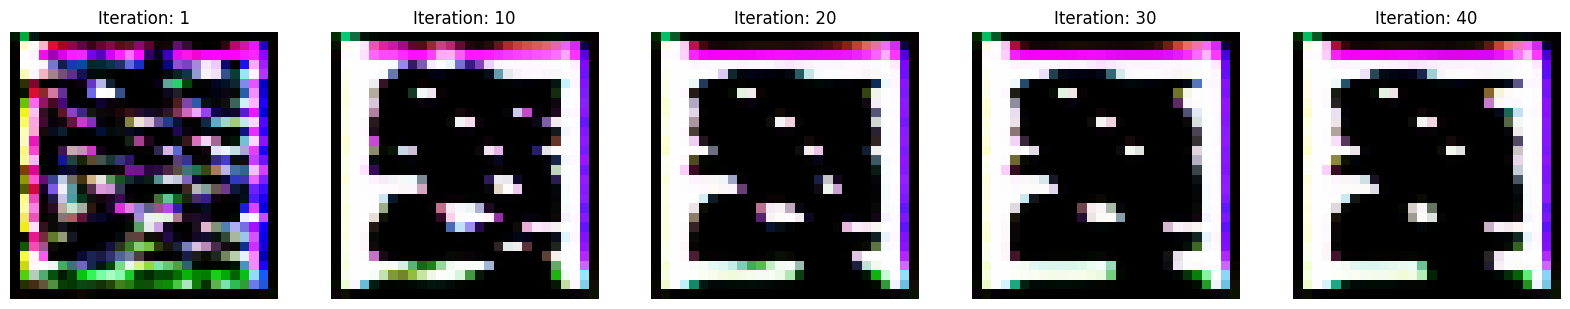

Epoch 7100, Loss: 5.0202772399643436e-05


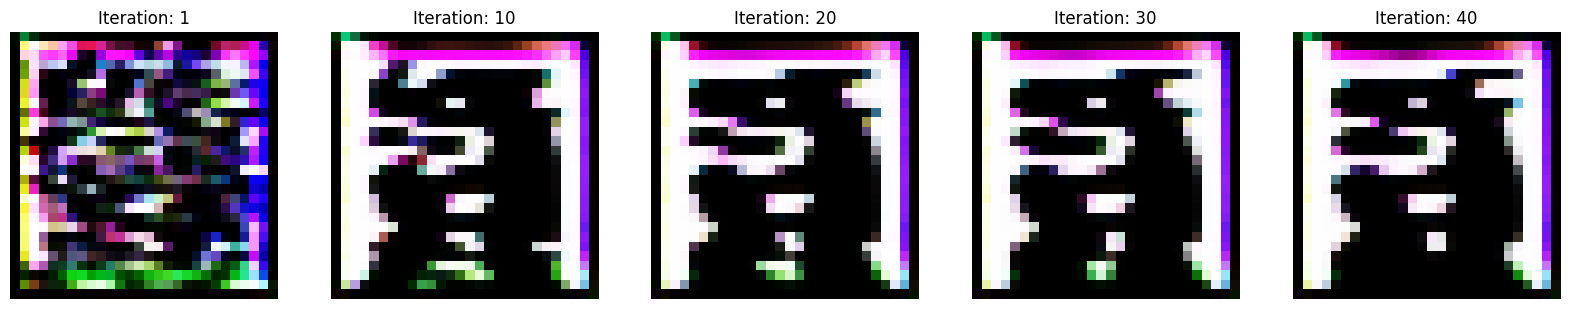

Epoch 7200, Loss: 4.9316859076498076e-05


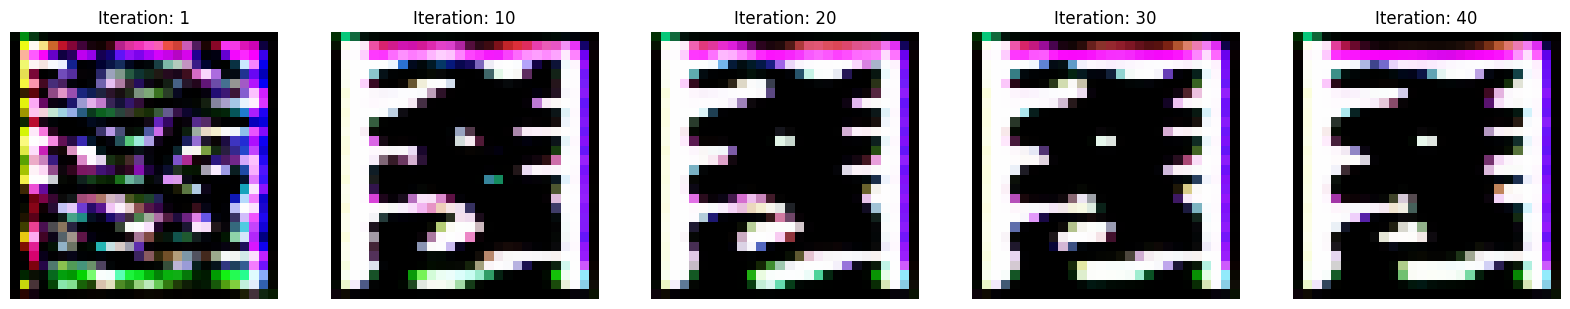

Epoch 7300, Loss: 4.8638983571436256e-05


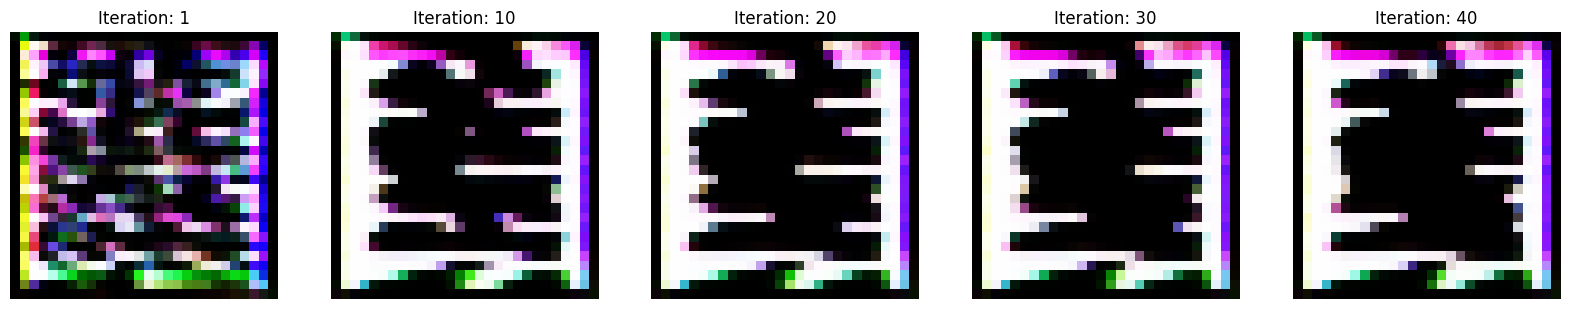

Epoch 7400, Loss: 4.789069134858437e-05


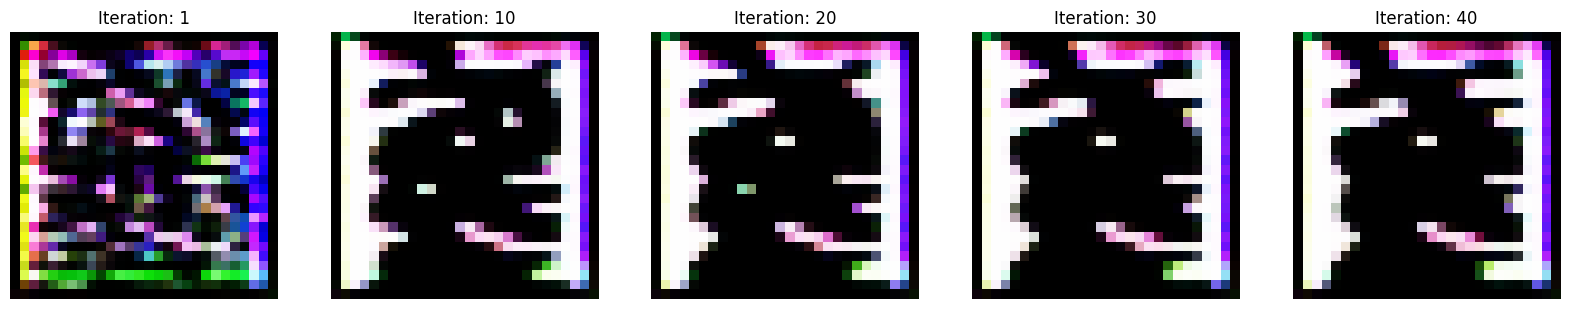

Epoch 7500, Loss: 4.703784725279547e-05


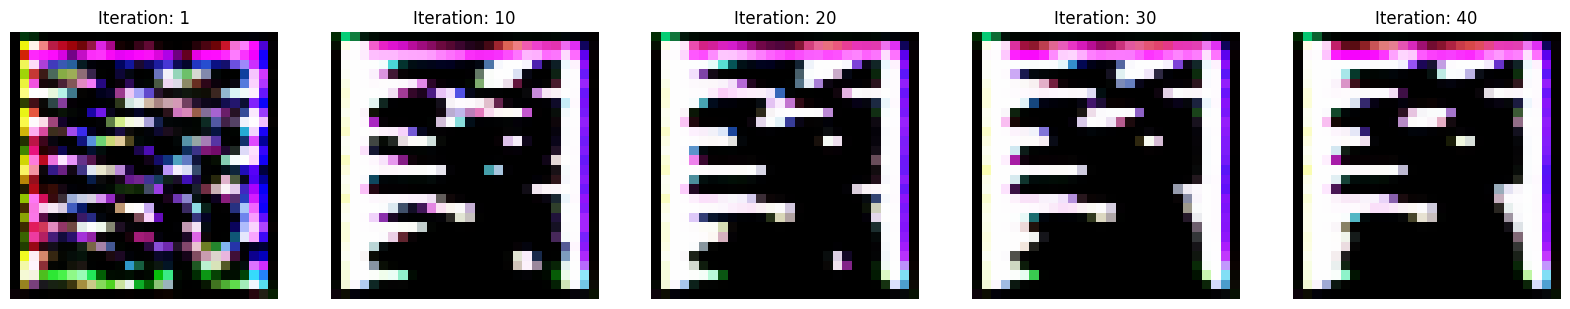

Epoch 7600, Loss: 4.6411882067332044e-05


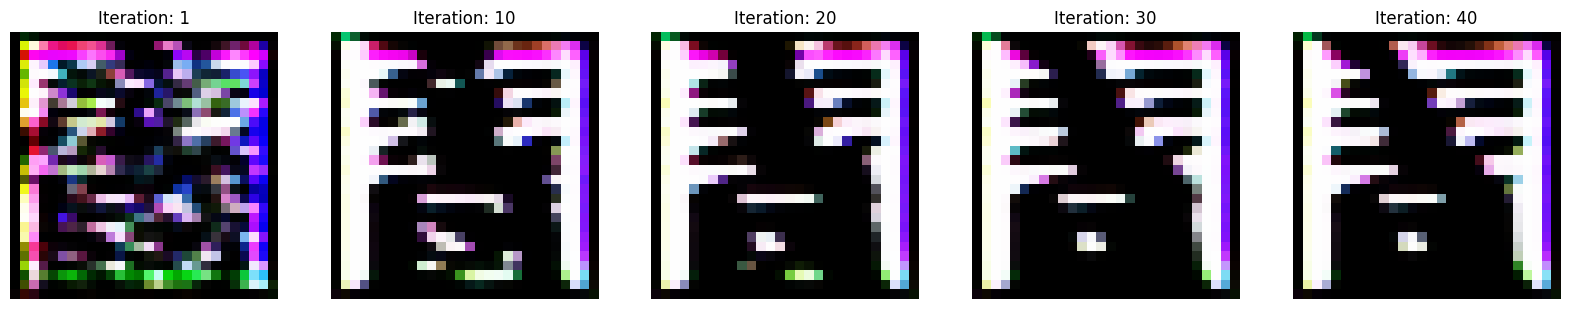

Epoch 7700, Loss: 4.5524142478825524e-05


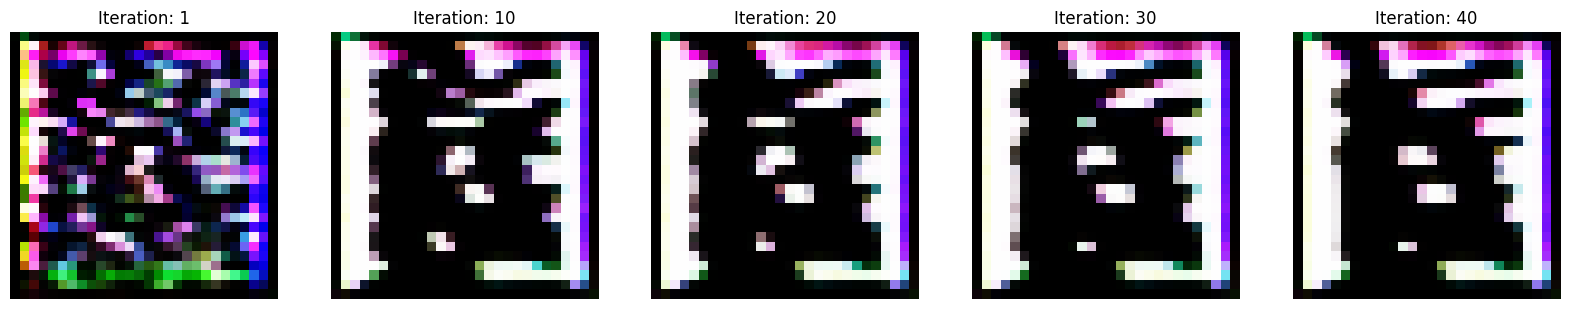

Epoch 7800, Loss: 4.5018354285275564e-05


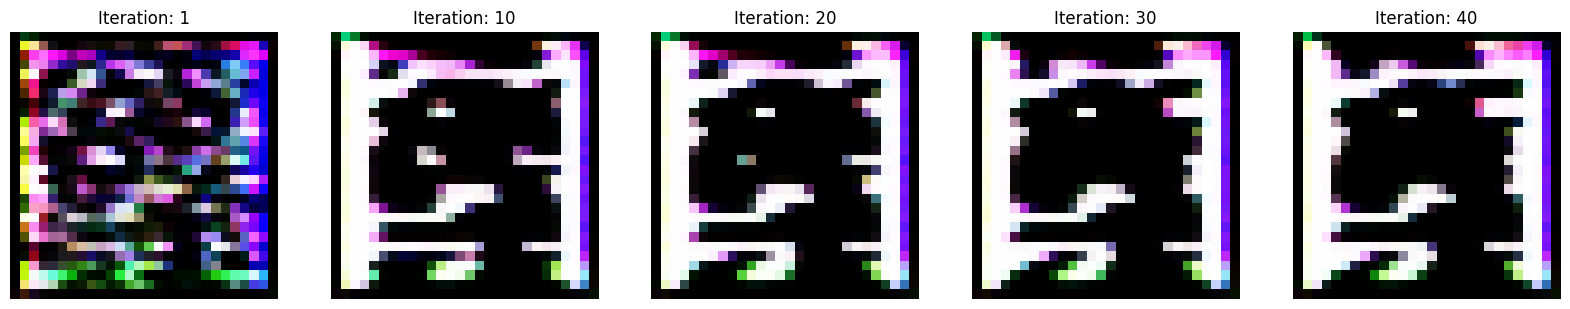

Epoch 7900, Loss: 4.419542528921738e-05


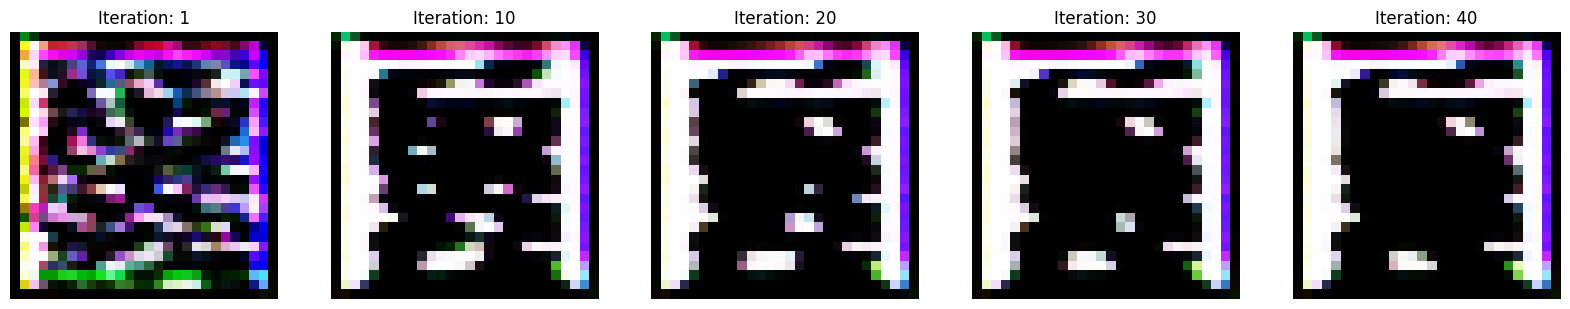

Epoch 8000, Loss: 4.330575029598549e-05


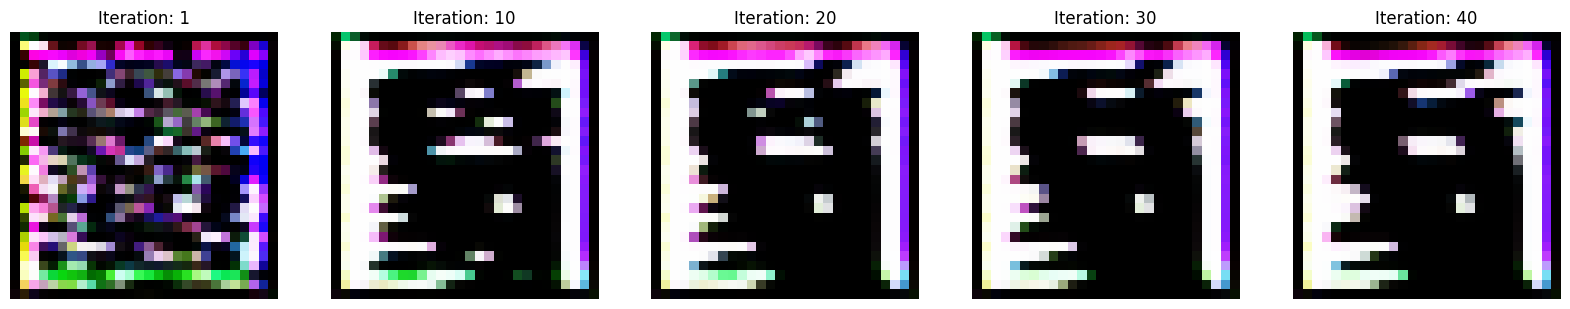

Epoch 8100, Loss: 4.266888936399482e-05


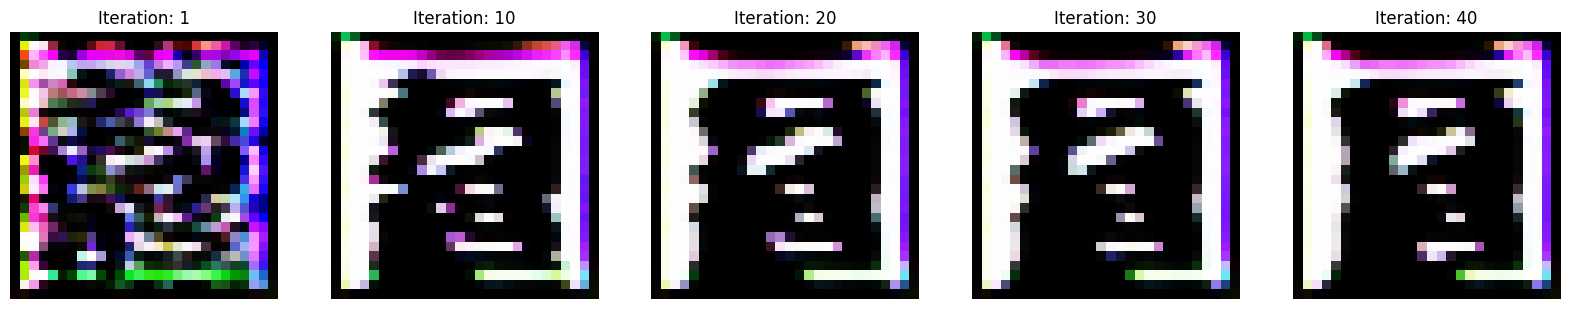

Epoch 8200, Loss: 4.2096649849554524e-05


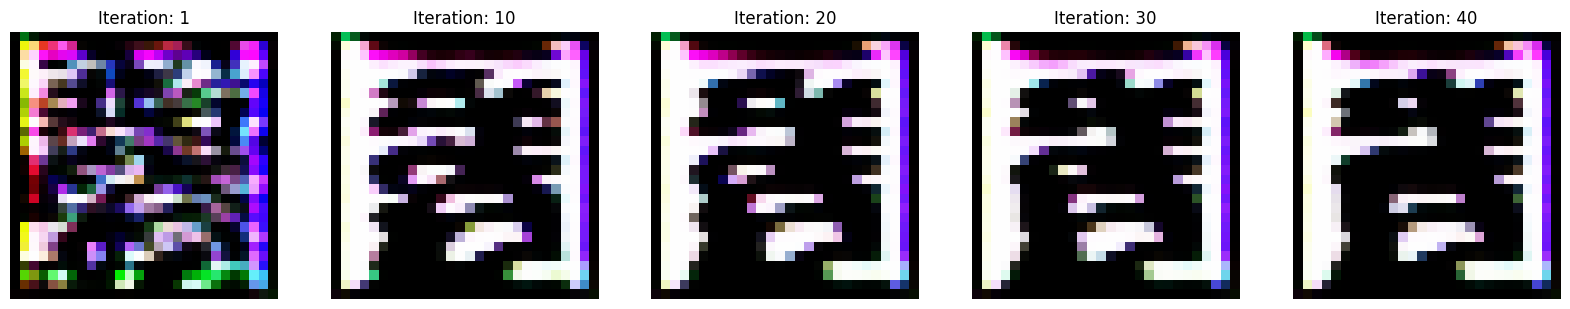

Epoch 8300, Loss: 4.156439899816178e-05


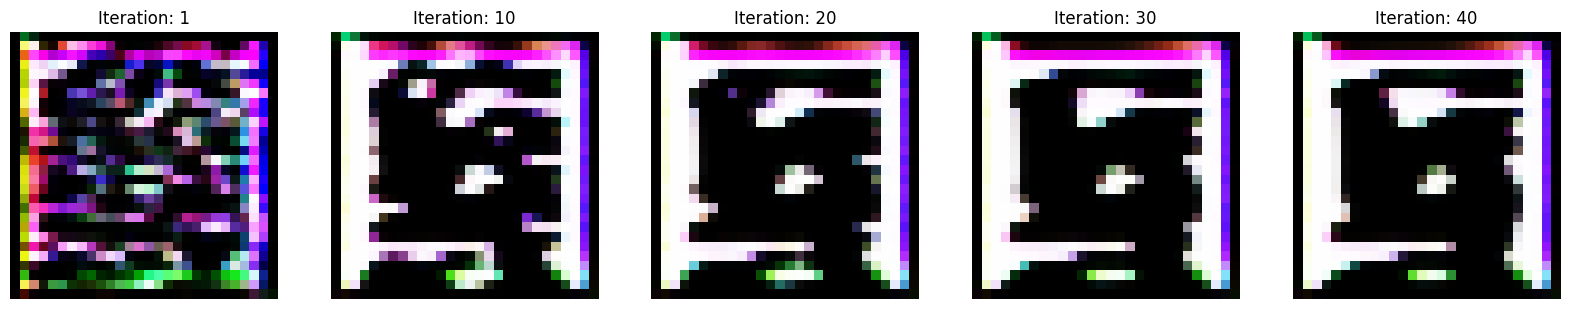

Epoch 8400, Loss: 4.104014078620821e-05


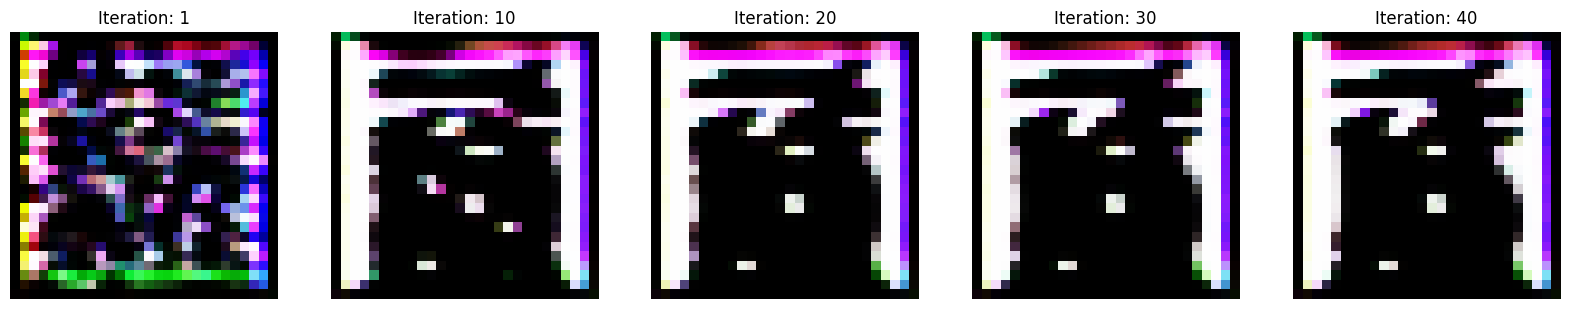

Epoch 8500, Loss: 4.02817313442938e-05


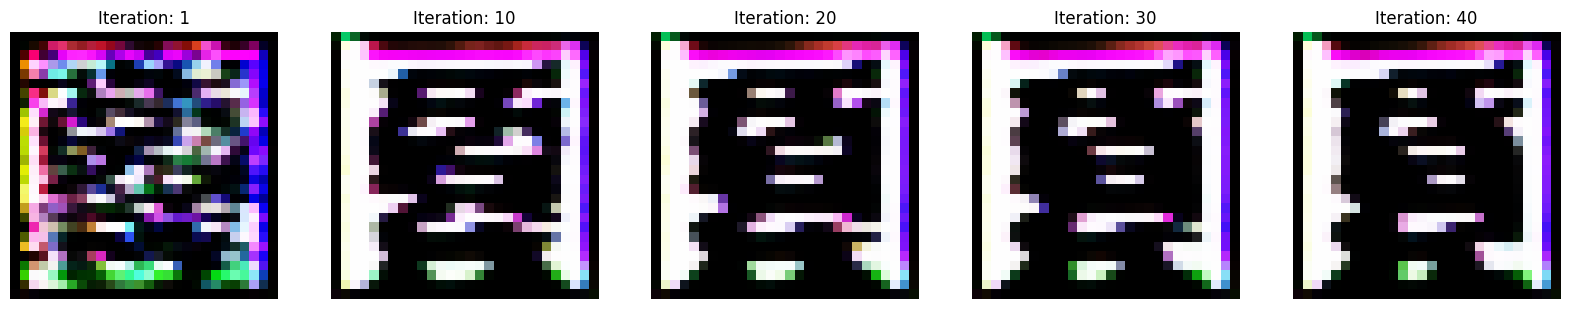

Epoch 8600, Loss: 3.9693855796940625e-05


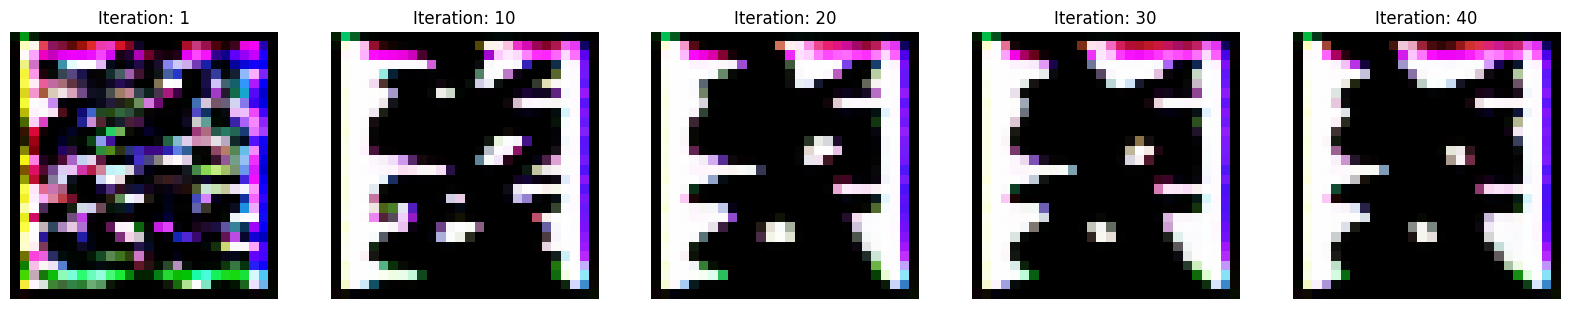

Epoch 8700, Loss: 3.9266120438696817e-05


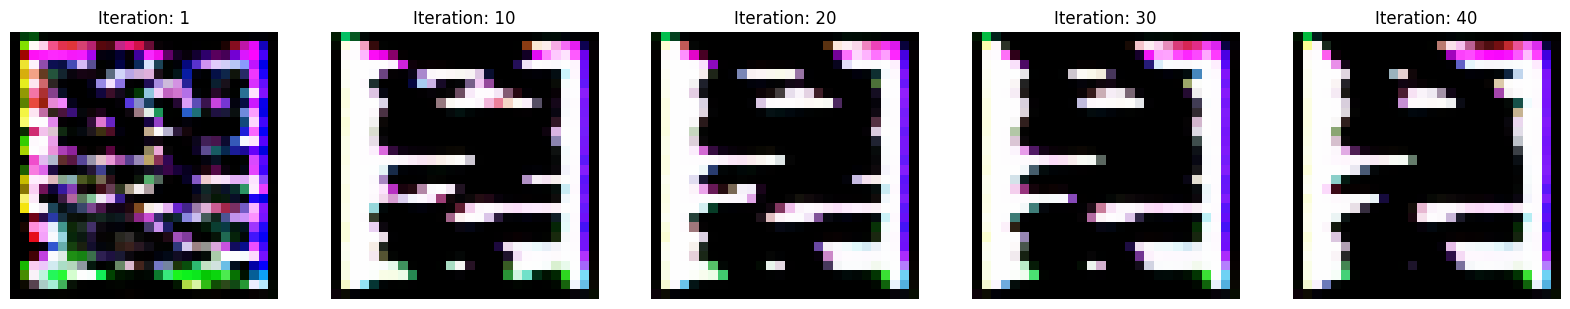

Epoch 8800, Loss: 3.937607107218355e-05


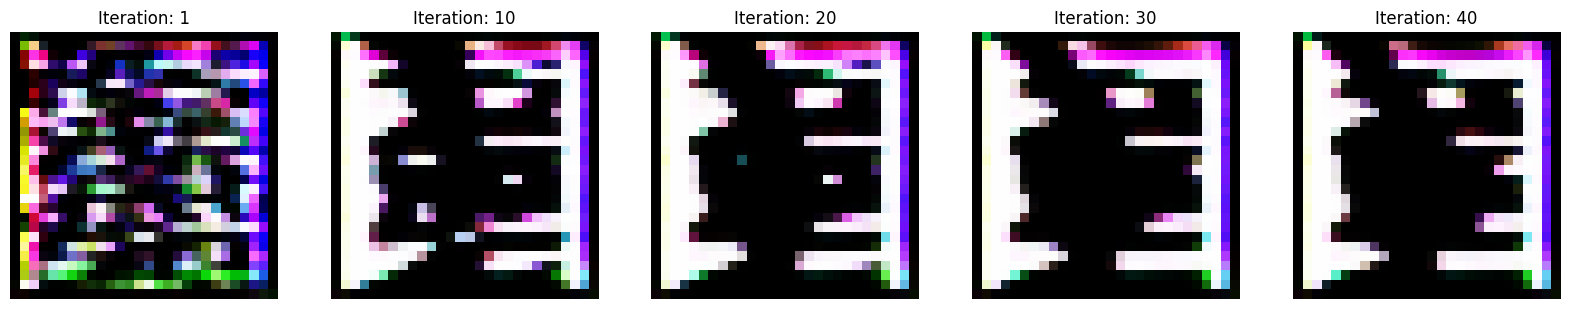

Epoch 8900, Loss: 3.8568308809772134e-05


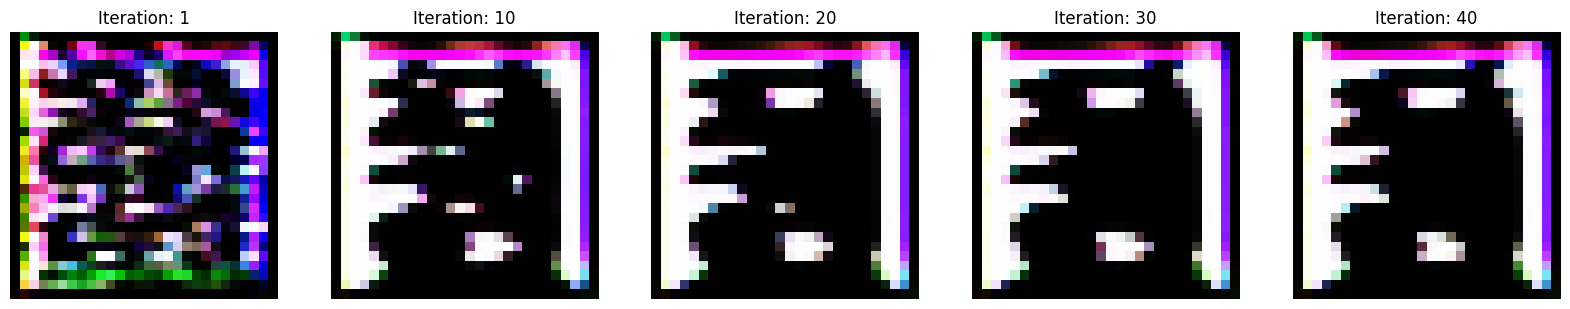

Epoch 9000, Loss: 3.769703471334651e-05


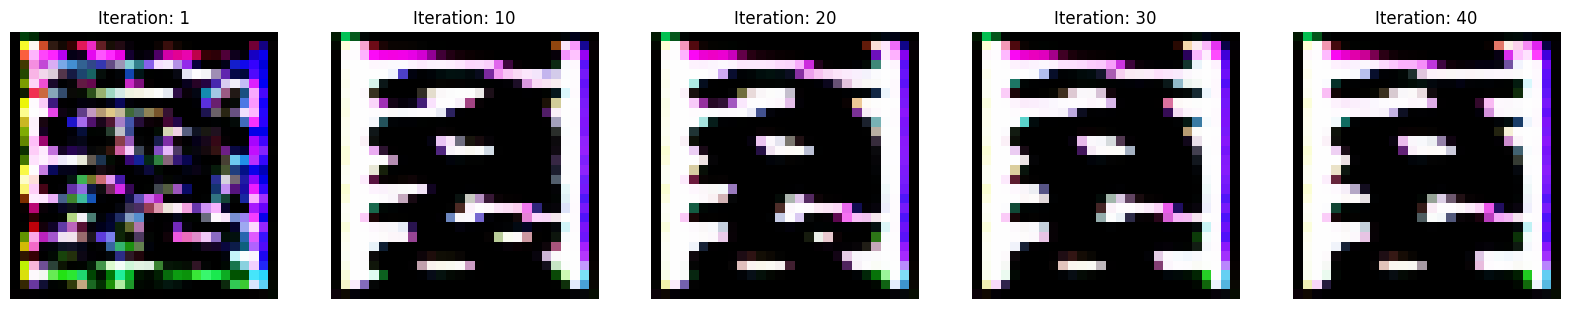

Epoch 9100, Loss: 3.709618977154605e-05


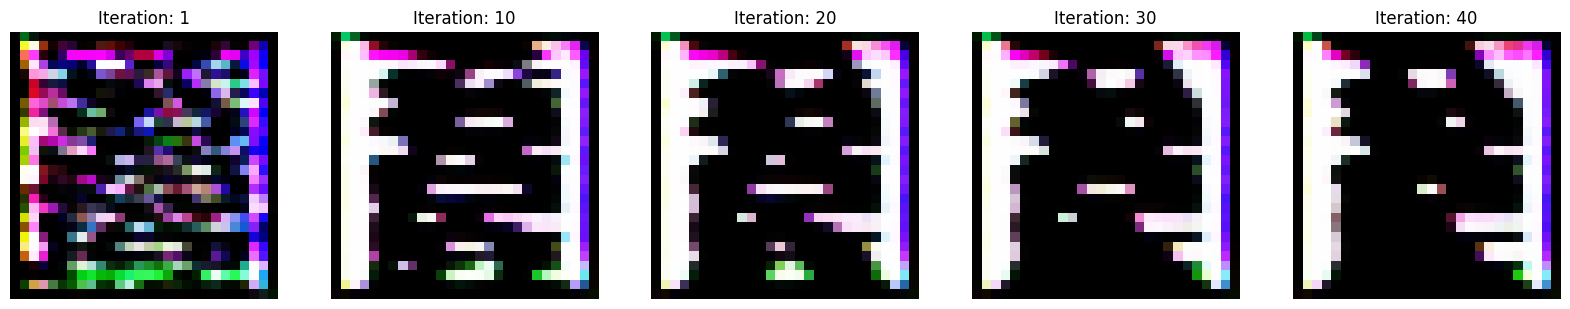

Epoch 9200, Loss: 3.676185951917432e-05


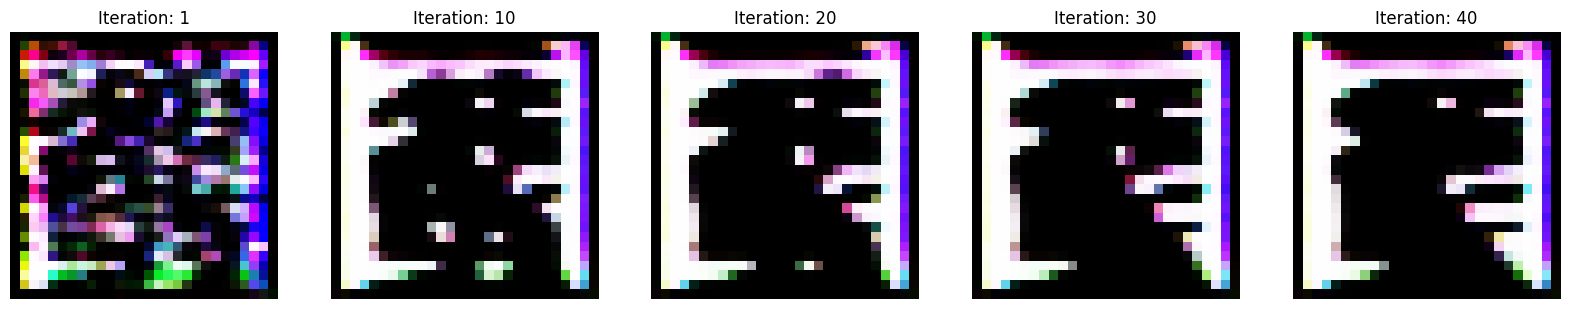

Epoch 9300, Loss: 3.6380606616148725e-05


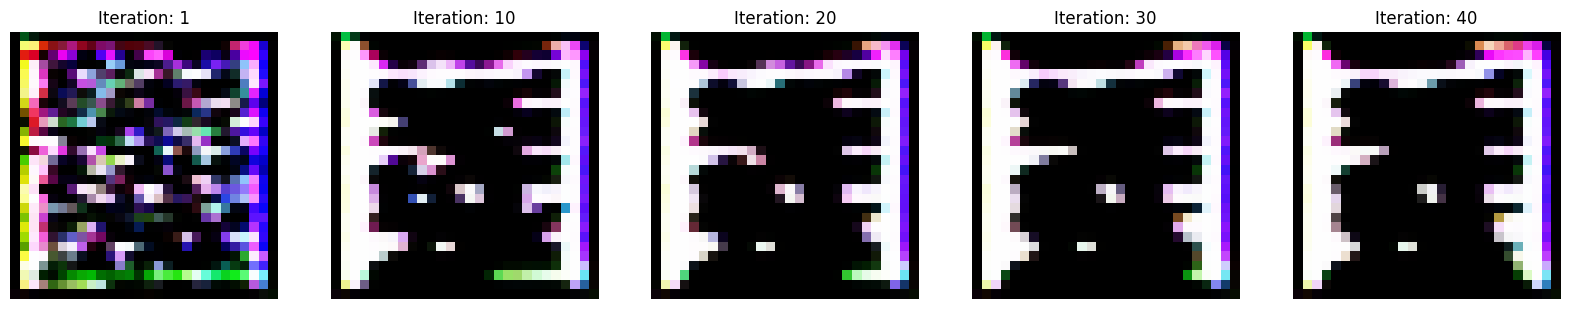

Epoch 9400, Loss: 3.561925404937938e-05


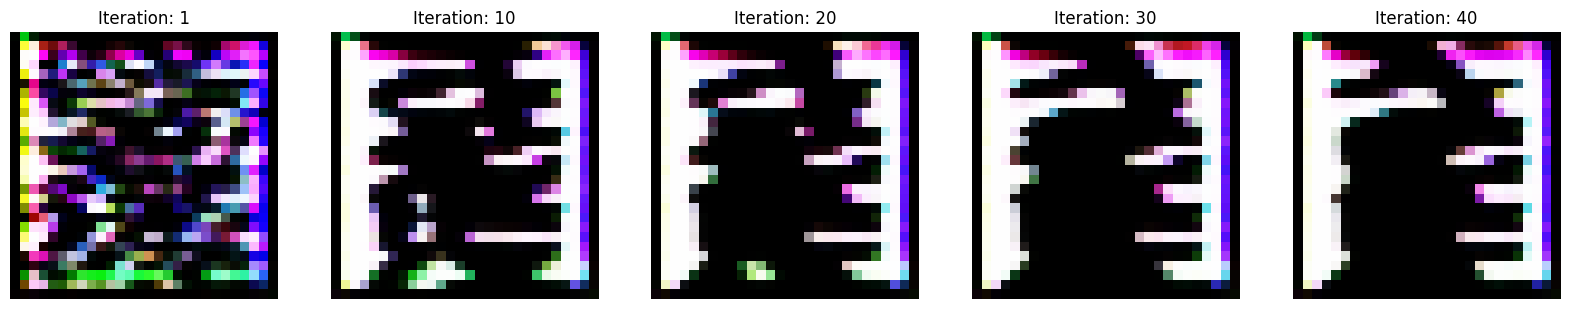

Epoch 9500, Loss: 3.528704837663099e-05


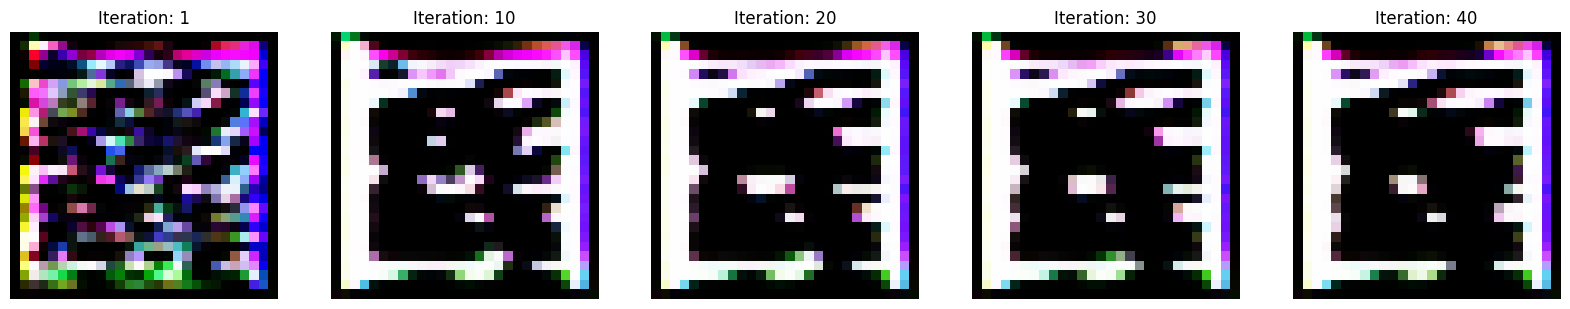

Epoch 9600, Loss: 3.468884460744448e-05


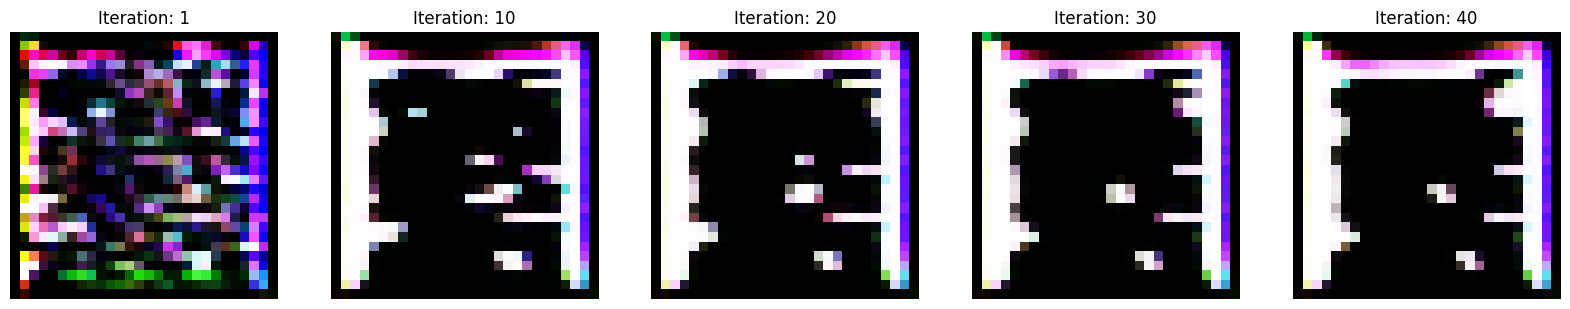

Epoch 9700, Loss: 3.4595919714774936e-05


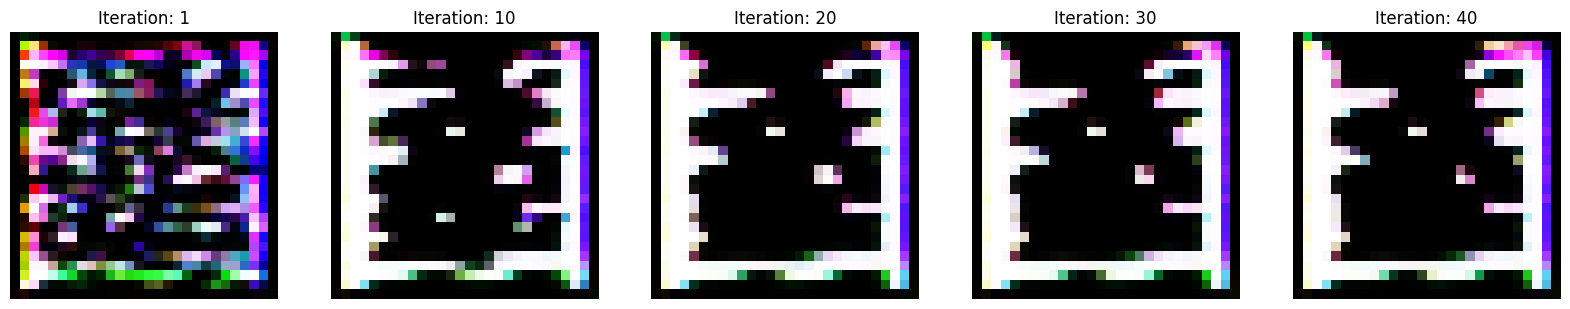

Epoch 9800, Loss: 3.3771215385058895e-05


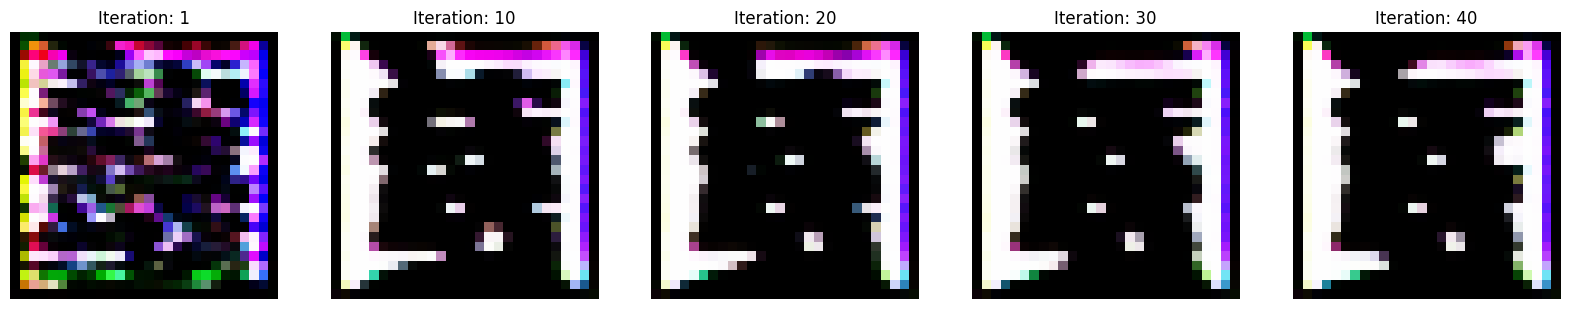

Epoch 9900, Loss: 3.335122164571658e-05


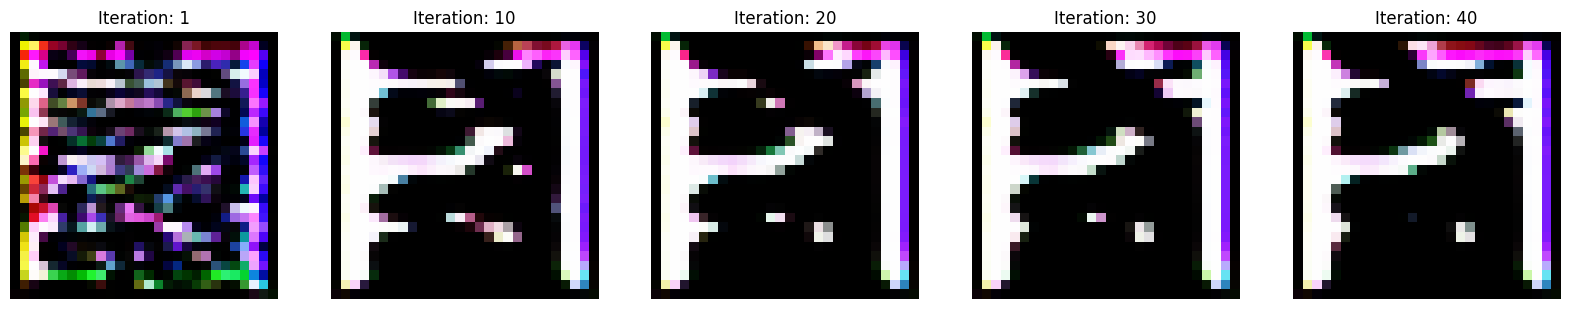

Epoch 10000, Loss: 3.266528437961824e-05


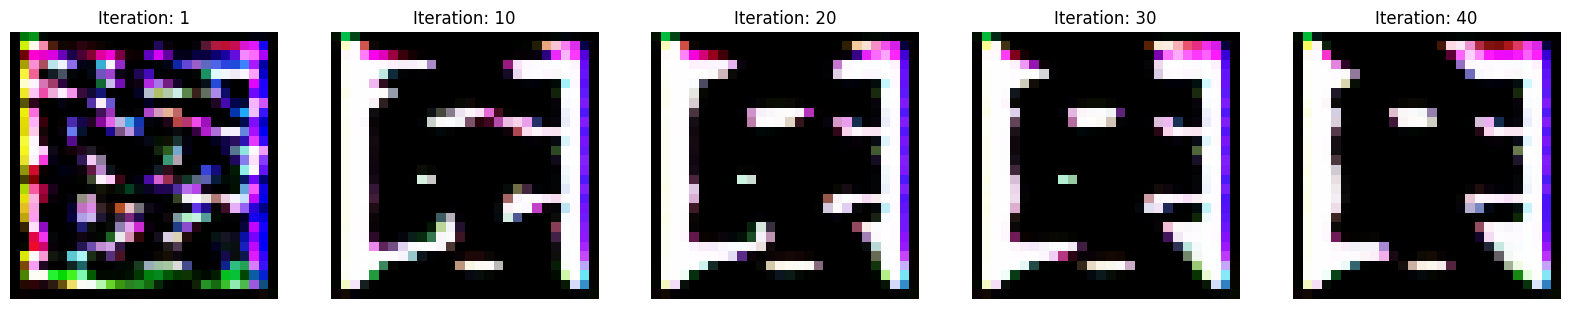

In [16]:
num_epochs = 10_000

model.train()
for epoch in range(num_epochs):
    for images, noised_images, _ in dataloader:
        optimizer.zero_grad()
        images = images.to(device).float()
        output_images = model(images)

        loss = criterion(output_images, images)
        loss.backward()
        first_batch = False

        optimizer.step()

    if (epoch+1)%100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        display_generated_images_at_intervals(model)


In [18]:

torch.save(model, "10_000-epochs.pth")


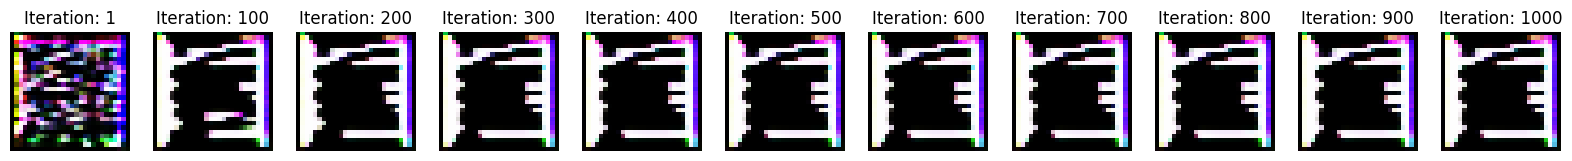

In [19]:
display_generated_images_at_intervals(model, n_iterations=1_000, interval=100)


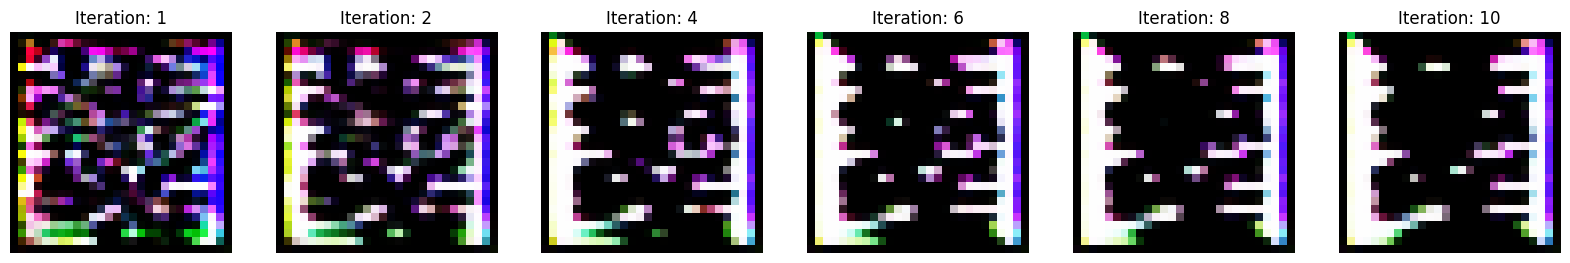

In [20]:
display_generated_images_at_intervals(model, n_iterations=10, interval=2)
